In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import geopandas as gpd
import math
from matplotlib.colors import TwoSlopeNorm, Normalize
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import json
import matplotlib.cm as cm
from tqdm import tqdm

In [2]:
AEO = pd.read_csv(r'D:\LBNL\BPA BSS\cost_table_for_viz\AEO_reference.csv')
AEO['total'] = AEO.drop(columns=['Year']).sum(axis=1)
AEO.head(2)

Year  Commercial: Natural Gas 2024 $/MMBtu  \
0  2050                              9.975012   
1  2049                             10.025811   

   Commercial: Electricity 2024 $/MMBtu  \
0                             35.383961   
1                             35.484558   

   Residential: Natural Gas 2024 $/MMBtu  \
0                              13.378824   
1                              13.404645   

   Residential: Electricity 2024 $/MMBtu       total  
0                              43.748291  102.486088  
1                              43.759800  102.674814

In [3]:
ineff = pd.read_csv('D:\LBNL\BPA BSS\cost_table_for_viz\ineff.json.csv')
mid = pd.read_csv('D:\LBNL\BPA BSS\cost_table_for_viz\mid.json.csv')
stated = pd.read_csv('D:\LBNL\BPA BSS\cost_table_for_viz\stated.json.csv')
high = pd.read_csv('D:\LBNL\BPA BSS\cost_table_for_viz\high.json.csv')
breakthrough = pd.read_csv(r'D:\LBNL\BPA BSS\cost_table_for_viz\breakthrough.json.csv')

In [4]:
ineff['scenario'] = 'ineff'
mid['scenario'] = 'mid'
stated['scenario'] = 'stated'
high['scenario'] = 'high'
breakthrough['scenario'] = 'breakthrough'

cost_all_scenario = pd.concat([ineff, mid, stated, high, breakthrough], ignore_index=True)

# Annual plots

## Total cost

In [5]:
filtered = cost_all_scenario[
    cost_all_scenario['metric'].isin(['Efficient Energy Cost (USD)'])
]
ref_case = ineff[ineff['metric'].isin(['Baseline Energy Cost (USD)'])].copy()
ref_case['scenario'] = 'ref'
combined_df = pd.concat([filtered, ref_case], ignore_index=True)

grouped = (
    combined_df.groupby(['year', 'scenario'])['value']
    .sum()
    .reset_index()
)

# Pivot for easier plotting
pivot = grouped.pivot_table(index='year', columns=['scenario'], values='value')
pivot = pivot/1e9
pivot.head(2)

scenario  breakthrough        high       ineff         mid         ref  \
year                                                                     
2024        531.060855  531.120732  533.761708  531.517422  532.744045   
2025        510.763614  510.860443  516.341540  511.696893  514.056148   

scenario      stated  
year                  
2024      532.089995  
2025      512.829633

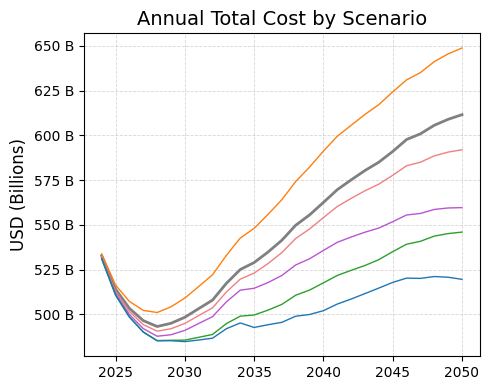

In [6]:
# Define fixed colors for each scenario
scenario_colors = {
    'ref':'grey',
    'ineff': 'tab:orange',
    'stated': 'lightcoral',
    'mid': 'mediumorchid',
    'high': 'tab:green',
    'breakthrough': 'tab:blue'
}
scenario_labels = {
    'ref': 'Reference',
    'stated': 'Stated Policies',
    'mid': 'Mid',
    'high': 'High',
    'breakthrough': 'Breakthrough',
    'ineff': 'Inefficient Electrification'
}
pivot = pivot.reindex(columns=list(scenario_colors.keys()))

fig, ax = plt.subplots(figsize=(5, 4))

for scenario in pivot.columns:    
    color = scenario_colors[scenario]
    linewidth = 2 if scenario.lower() in ['ref', 'reference'] else 1
    ax.plot(
        pivot.index,
        pivot[scenario],
        label=scenario_labels.get(scenario, scenario),
        color=color,
        linewidth=linewidth
    )
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, title='', fontsize=9)
# Format y-axis
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f} B'))

# Custom x-ticks
ax.grid(visible=True, linestyle='--', linewidth=0.6, alpha=0.5)
ax.set_xticks([y for y in pivot.index if y % 5 == 0 and y >= 2025])


ax.set_ylabel("USD (Billions)", fontsize=12)
title = "Annual Total Cost by Scenario"
ax.set_title(title, fontsize=14)
# ax.legend(title='', fontsize=9)

# Right y-axis
# ax2 = ax.twinx()
# ax2.plot(AEO['Year'], AEO['total'], label = 'AEO reference case', linestyle='-', color='black', linewidth=1.5) 
# ax2.set_ylabel("Price ($/MMBtu)", fontsize=12)
# ax2.tick_params(axis='y', labelcolor='black')

# # Combine legends from both axes
# lines1, labels1 = ax.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper center', ncol=2, fontsize=8)


plt.tight_layout()
# plt.savefig(f'cost_graph/{title}.png',transparent=True,bbox_inches='tight')

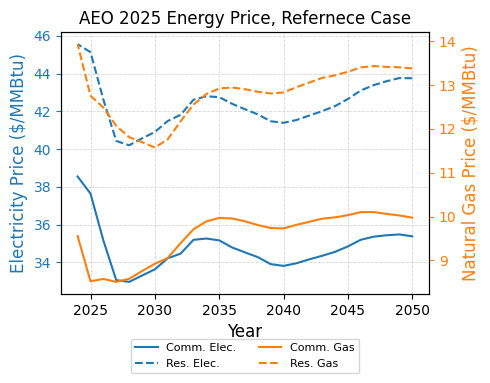

In [7]:
# Create a new figure and primary axis
fig, ax1 = plt.subplots(figsize=(5, 4))
ax2 = ax1.twinx()  # Secondary y-axis for natural gas

# Define column labels and styles
aeo_columns = {
    'Commercial: Natural Gas 2024 $/MMBtu': ('Comm. Gas', ax2),
    'Commercial: Electricity 2024 $/MMBtu': ('Comm. Elec.', ax1),
    'Residential: Natural Gas 2024 $/MMBtu': ('Res. Gas', ax2),
    'Residential: Electricity 2024 $/MMBtu': ('Res. Elec.', ax1)
}
linestyles = ['-','-','--','--']
colors = ['tab:orange', 'tab:blue', 'tab:orange', 'tab:blue']

# Plot each series on the designated axis
for i, (col, (label, axis)) in enumerate(aeo_columns.items()):
    axis.plot(
        AEO['Year'],
        AEO[col],
        label=label,
        linestyle=linestyles[i],
        color=colors[i],
        linewidth=1.5
    )

# Axis formatting
# Axis formatting
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Electricity Price ($/MMBtu)", fontsize=12, color='tab:blue')
ax2.set_ylabel("Natural Gas Price ($/MMBtu)", fontsize=12, color='tab:orange')

# Color y-axis ticks to match the lines
ax1.tick_params(axis='y', labelsize=10, colors='tab:blue')
ax2.tick_params(axis='y', labelsize=10, colors='tab:orange')
ax1.tick_params(axis='x', labelsize=10)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=8)
ax1.grid(visible=True, linestyle='--', linewidth=0.6, alpha=0.5)
plt.title('AEO 2025 Energy Price, Refernece Case')
plt.tight_layout()
plt.savefig(f'cost_graph/AEO_refprice.png',transparent=True,bbox_inches='tight')

## Sector scenarios

In [8]:
# Group bldg_type → sector
combined_df['sector'] = combined_df['bldg_type'].str.extract(r'(Residential|Commercial)')

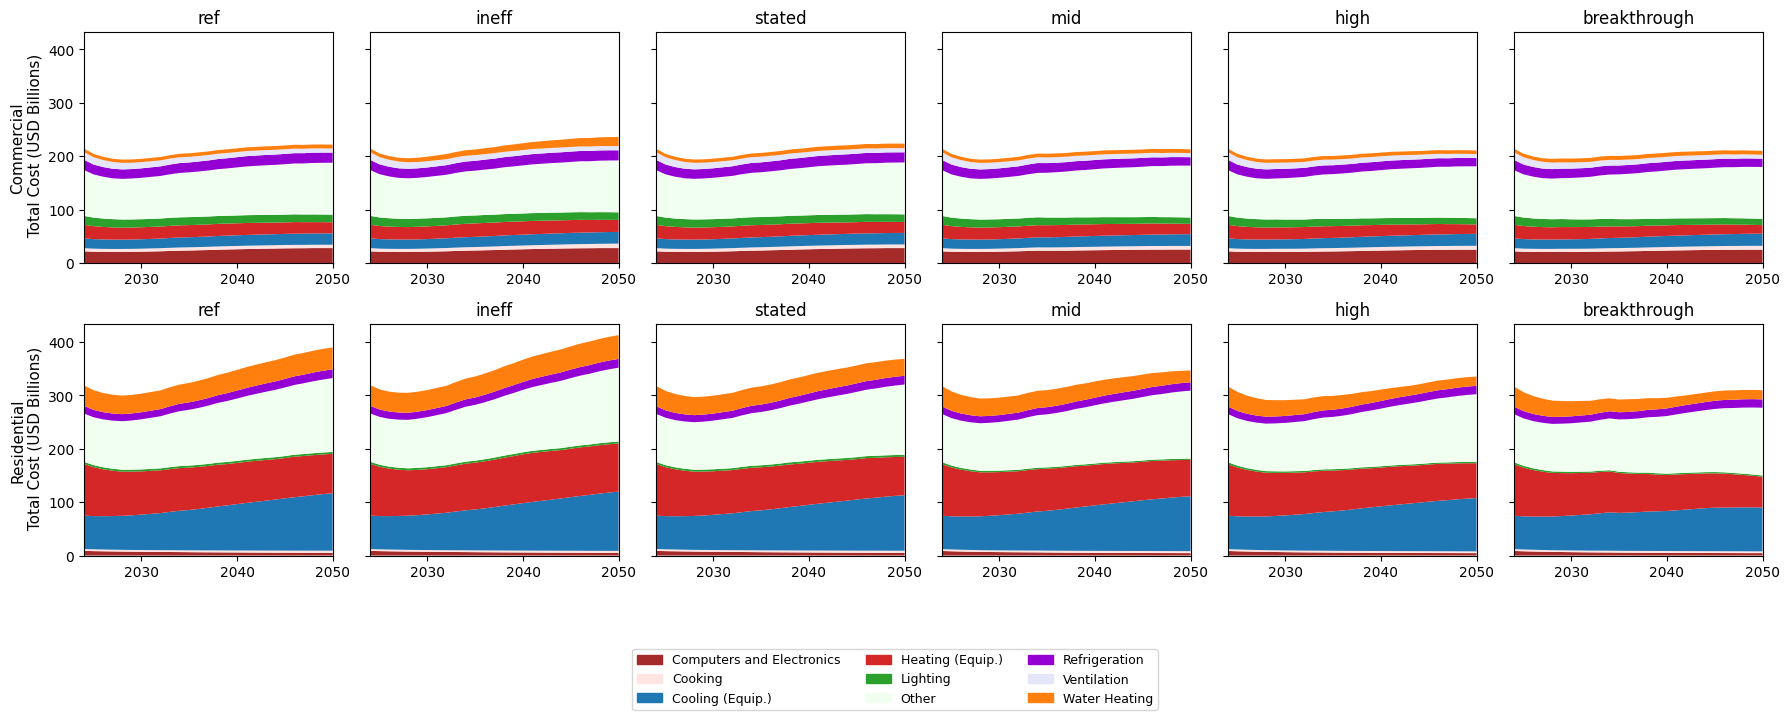

In [9]:


# Aggregate
agg = combined_df.groupby(['scenario', 'sector', 'year', 'end_use'])['value'].sum().reset_index()

# Get unique values
scenario_order = ['ref', 'ineff', 'stated', 'mid', 'high', 'breakthrough']

# Filter to include only existing scenarios from the data
scenarios = [s for s in scenario_order if s in agg['scenario'].unique()]
sectors = ['Commercial', 'Residential']
end_uses = sorted(agg['end_use'].unique())
end_use_colors = {
    'Computers and Electronics': 'brown',
    'Cooking': 'mistyrose',
    'Cooling (Equip.)': 'tab:blue',
    'Heating (Equip.)': 'tab:red',
    'Lighting': 'tab:green',
    'Other': 'honeydew',
    'Refrigeration': 'darkviolet',
    'Ventilation': 'lavender',
    'Water Heating': 'tab:orange'
}

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=len(scenarios), figsize=(3*len(scenarios), 6), sharey=True)

# Plot
for i, sector in enumerate(sectors):
    for j, scenario in enumerate(scenarios):
        ax = axes[i][j] if len(scenarios) > 1 else axes[i]

        # Filter and pivot
        data = agg[(agg['sector'] == sector) & (agg['scenario'] == scenario)]
        pivot = data.pivot(index='year', columns='end_use', values='value').fillna(0)

        # Reorder columns to match color assignment
        pivot = pivot[[eu for eu in end_uses if eu in pivot.columns]]

        # Plot stacked area
        ax.stackplot(pivot.index, pivot.T, labels=pivot.columns, colors=[end_use_colors[eu] for eu in pivot.columns])

        ax.set_title(scenario, fontsize=12)
        if j == 0:
            ax.set_ylabel(f"{sector}\n Total Cost (USD Billions)", fontsize=11)
        else:
            ax.set_yticklabels([])

        ax.set_xlim(pivot.index.min(), pivot.index.max())
        ax.set_xticks([2030, 2040, 2050])
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1e9:,.0f}'))


# Legend
handles = [plt.Rectangle((0, 0), 1, 1, color=end_use_colors[eu]) for eu in end_uses if eu in end_use_colors]
labels = [eu for eu in end_uses if eu in end_use_colors]
fig.legend(
    handles, end_uses,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.08),  # Adjust as needed
    ncol=3, fontsize=9
)
title = 'Annual Total Cost by Scenarios and Sectors'
plt.tight_layout()
# plt.savefig(f'cost_graph/{title}_sector_scenario.png', transparent=True, bbox_inches='tight')


## Total cost savings

In [10]:
ineff['metric'].unique()

array(['Baseline Energy Cost (USD)', 'Efficient Energy Cost (USD)',
       'Energy Cost Savings (USD)'], dtype=object)

In [50]:
filtered = cost_all_scenario[
    cost_all_scenario['metric'].isin(['Energy Cost Savings (USD)'])
]
combined_df = pd.concat([filtered, ref_case], ignore_index=True)

grouped = (
    filtered.groupby(['year', 'scenario'])['value']
    .sum()
    .reset_index()
)

# Pivot for easier plotting
pivot = grouped.pivot_table(index='year', columns=['scenario'], values='value')
pivot = pivot/1e9
pivot.head(2)

scenario  breakthrough      high     ineff       mid    stated
year                                                          
2024          1.683190  1.623313 -1.017663  1.282018  0.759763
2025          3.292534  3.195705 -2.285393  2.479637  1.456681

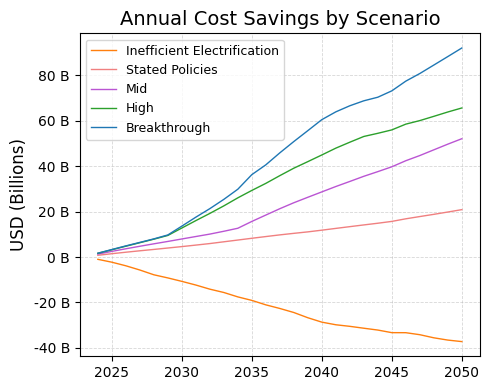

In [12]:
# Define fixed colors for each scenario
scenario_colors = {
    # 'ref':'grey',
    'ineff': 'tab:orange',
    'stated': 'lightcoral',
    'mid': 'mediumorchid',
    'high': 'tab:green',
    'breakthrough': 'tab:blue'
}
scenario_labels = {
    # 'ref': 'Reference',
    'stated': 'Stated Policies',
    'mid': 'Mid',
    'high': 'High',
    'breakthrough': 'Breakthrough',
    'ineff': 'Inefficient Electrification'
}
pivot = pivot.reindex(columns=list(scenario_colors.keys()))

fig, ax = plt.subplots(figsize=(5, 4))

for scenario in pivot.columns:    
    color = scenario_colors[scenario]
    linewidth = 2 if scenario.lower() in ['ref', 'reference'] else 1
    ax.plot(
        pivot.index,
        pivot[scenario],
        label=scenario_labels.get(scenario, scenario),
        color=color,
        linewidth=linewidth
    )
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='', fontsize=9)
# Format y-axis
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f} B'))

# Custom x-ticks
ax.grid(visible=True, linestyle='--', linewidth=0.6, alpha=0.5)
ax.set_xticks([y for y in pivot.index if y % 5 == 0 and y >= 2025])


ax.set_ylabel("USD (Billions)", fontsize=12)
title = "Annual Cost Savings by Scenario"
ax.set_title(title, fontsize=14)
ax.legend(title='', fontsize=9)

plt.tight_layout()
# plt.savefig(f'cost_graph/{title}.png',transparent=True,bbox_inches='tight')

## Sector scenarios - Heating / Cooling / Non mechanics

In [51]:
measure_map = pd.read_csv('map_meas/measure_map.tsv', sep='\t')
combined_df = combined_df.merge(
    measure_map[['meas', 'measure_desc_simple']],
    on='meas',
    how='left'
)
combined_df.head(2)

meas            adoption_scn                     metric  \
0  (R) Ref. Case Gas Dryer  Max adoption potential  Energy Cost Savings (USD)   
1  (R) Ref. Case Gas Dryer  Max adoption potential  Energy Cost Savings (USD)   

  reg          bldg_type end_use          fuel  year  value scenario  \
0  AL  Residential (New)   Other  Non-Electric  2024    0.0    ineff   
1  AL  Residential (New)   Other  Non-Electric  2025    0.0    ineff   

  measure_desc_simple  
0       Dryer, fossil  
1       Dryer, fossil

In [166]:
def plot_enduses(combined_df, title):
    # Aggregate
    agg = combined_df.groupby(['scenario', 'sector', 'year','measure_desc_simple'])['value'].sum().reset_index()
    
    # Get unique values
    scenario_order = ['ref', 'ineff', 'stated', 'mid', 'high', 'breakthrough']
    
    # Filter to include only existing scenarios from the data
    scenarios = [s for s in scenario_order if s in agg['scenario'].unique()]
    sectors = ['Commercial', 'Residential']
    measures = sorted(agg['measure_desc_simple'].unique())
    # end_use_colors = {
    #     'Computers and Electronics': 'brown',
    #     'Cooking': 'mistyrose',
    #     'Cooling (Equip.)': 'tab:blue',
    #     'Heating (Equip.)': 'tab:red',
    #     'Lighting': 'tab:green',
    #     'Other': 'honeydew',
    #     'Refrigeration': 'darkviolet',
    #     'Ventilation': 'lavender',
    #     'Water Heating': 'tab:orange'
    # }
    cmap = cm.get_cmap('Set1', len(measures))
    meas_colors = {m: mcolors.to_hex(cmap(i)) for i, m in enumerate(measures)}
    # Create subplots
    fig, axes = plt.subplots(nrows=2, ncols=len(scenarios), figsize=(3*len(scenarios), 6), sharey=True)
    
    for i, sector in enumerate(sectors):
        for j, scenario in enumerate(scenarios):
            ax = axes[i][j] if len(scenarios) > 1 else axes[i]

            data = agg[(agg['sector'] == sector) & (agg['scenario'] == scenario)]
            pivot = data.pivot(index='year', columns='measure_desc_simple', values='value').fillna(0)
            pivot = pivot[[m for m in measures if m in pivot.columns]]

            ax.stackplot(pivot.index, pivot.T, labels=pivot.columns, colors=[meas_colors[m] for m in pivot.columns])

            ax.set_title(scenario, fontsize=12)
            if j == 0:
                ax.set_ylabel(f"{sector}\nTotal Cost (USD Billions)", fontsize=11)
            else:
                ax.set_yticklabels([])

            ax.set_xlim(pivot.index.min(), pivot.index.max())
            ax.set_xticks([2030, 2040, 2050])
            ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1e9:,.0f}'))

    
    
    # Legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=meas_colors[m]) for m in measures]
    fig.legend(
        handles, measures,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.08),
        ncol=3, fontsize=9
    )
    fig.suptitle(f"Total Cost by Measure for {title}", fontsize=16, y=1)
    plt.tight_layout()
    plt.savefig(f'cost_graph/total_cost_{title}_sector_scenario.png', transparent=True, bbox_inches='tight')

In [170]:
combined_df.head(2)

meas            adoption_scn  \
0  (R) Ref. Case Gas Dryer  Max adoption potential   
1  (R) Ref. Case Gas Dryer  Max adoption potential   

                        metric reg          bldg_type end_use          fuel  \
0  Efficient Energy Cost (USD)  AL  Residential (New)   Other  Non-Electric   
1  Efficient Energy Cost (USD)  AL  Residential (New)   Other  Non-Electric   

   year         value scenario measure_desc_simple  
0  2024  16467.406179    ineff       Dryer, fossil  
1  2025  32782.057045    ineff       Dryer, fossil

C:\Users\vapeu\AppData\Local\Temp\ipykernel_10896\3005769342.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set1', len(measures))


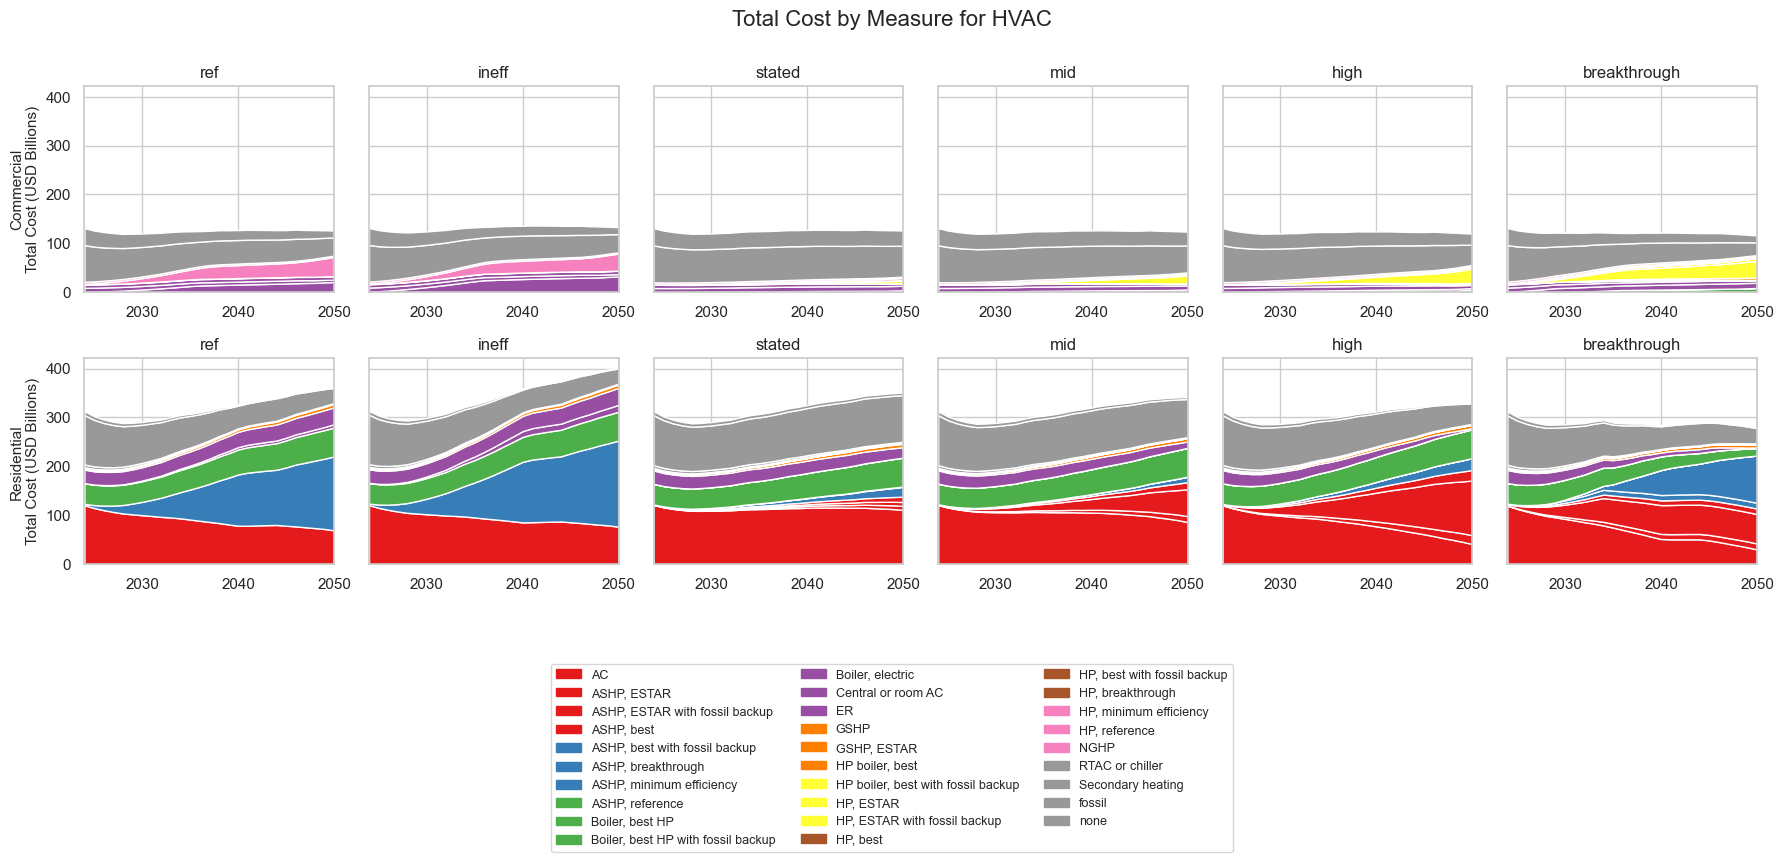

In [183]:
combined_df_hvac = combined_df[combined_df['end_use'].isin(['Heating (Equip.)', 'Cooling (Equip.)'])]
plot_enduses(combined_df_hvac, 'HVAC')

C:\Users\vapeu\AppData\Local\Temp\ipykernel_10896\3005769342.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set1', len(measures))


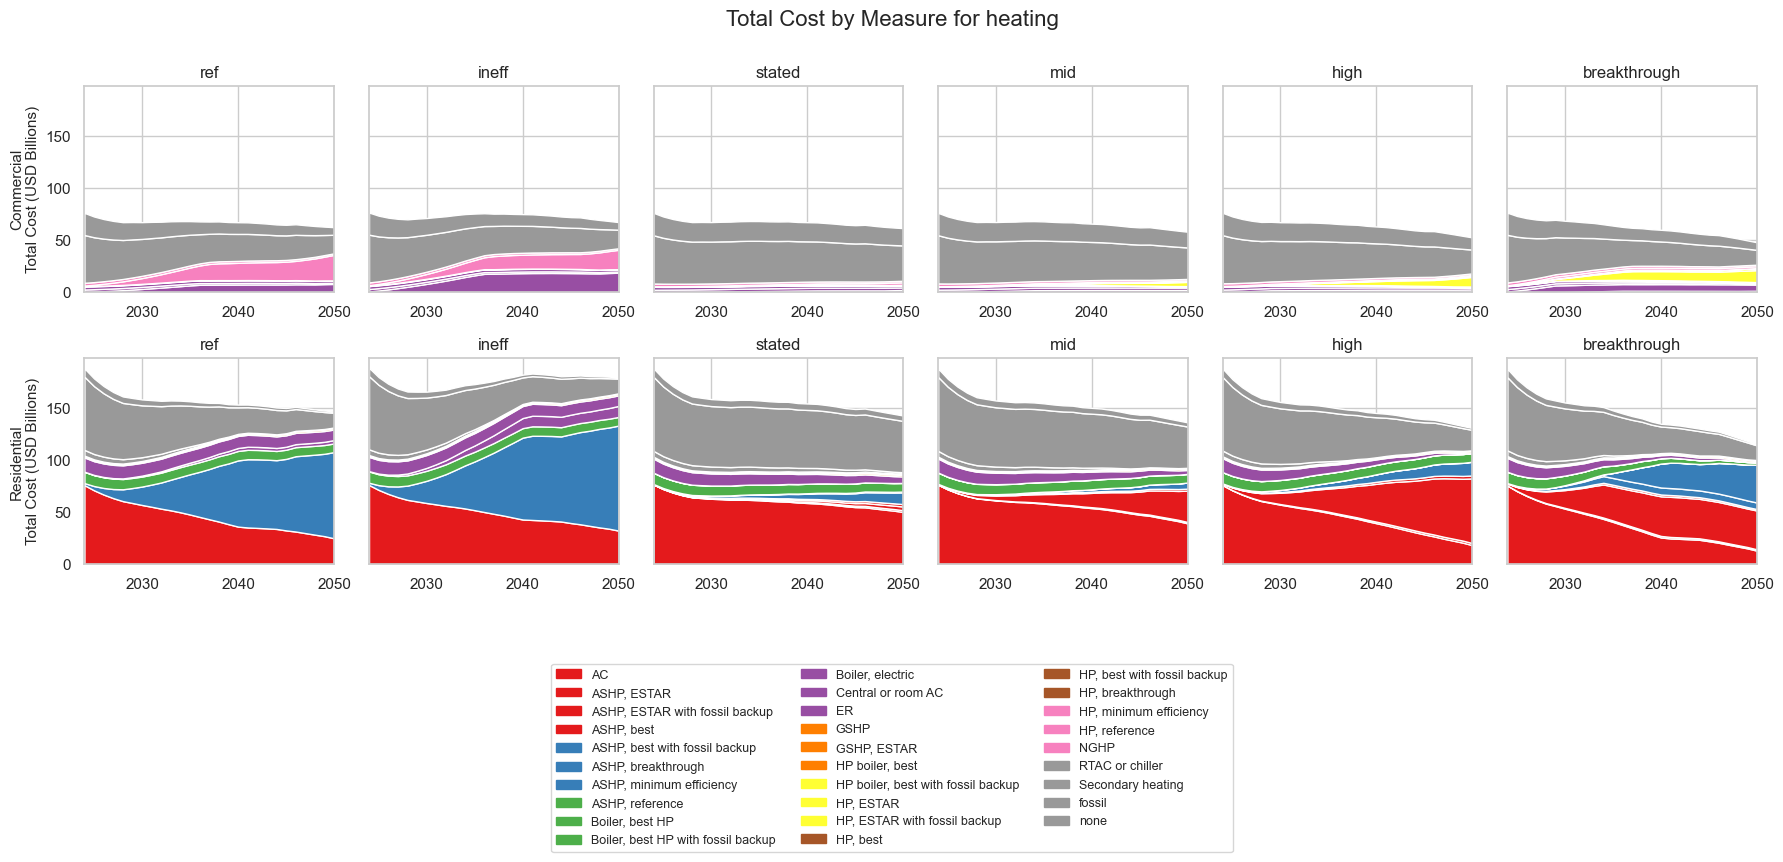

In [178]:
combined_df_heating = combined_df[combined_df['end_use'].isin(['Heating (Equip.)'])]
plot_enduses(combined_df_heating, 'heating')

C:\Users\vapeu\AppData\Local\Temp\ipykernel_10896\3005769342.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set1', len(measures))


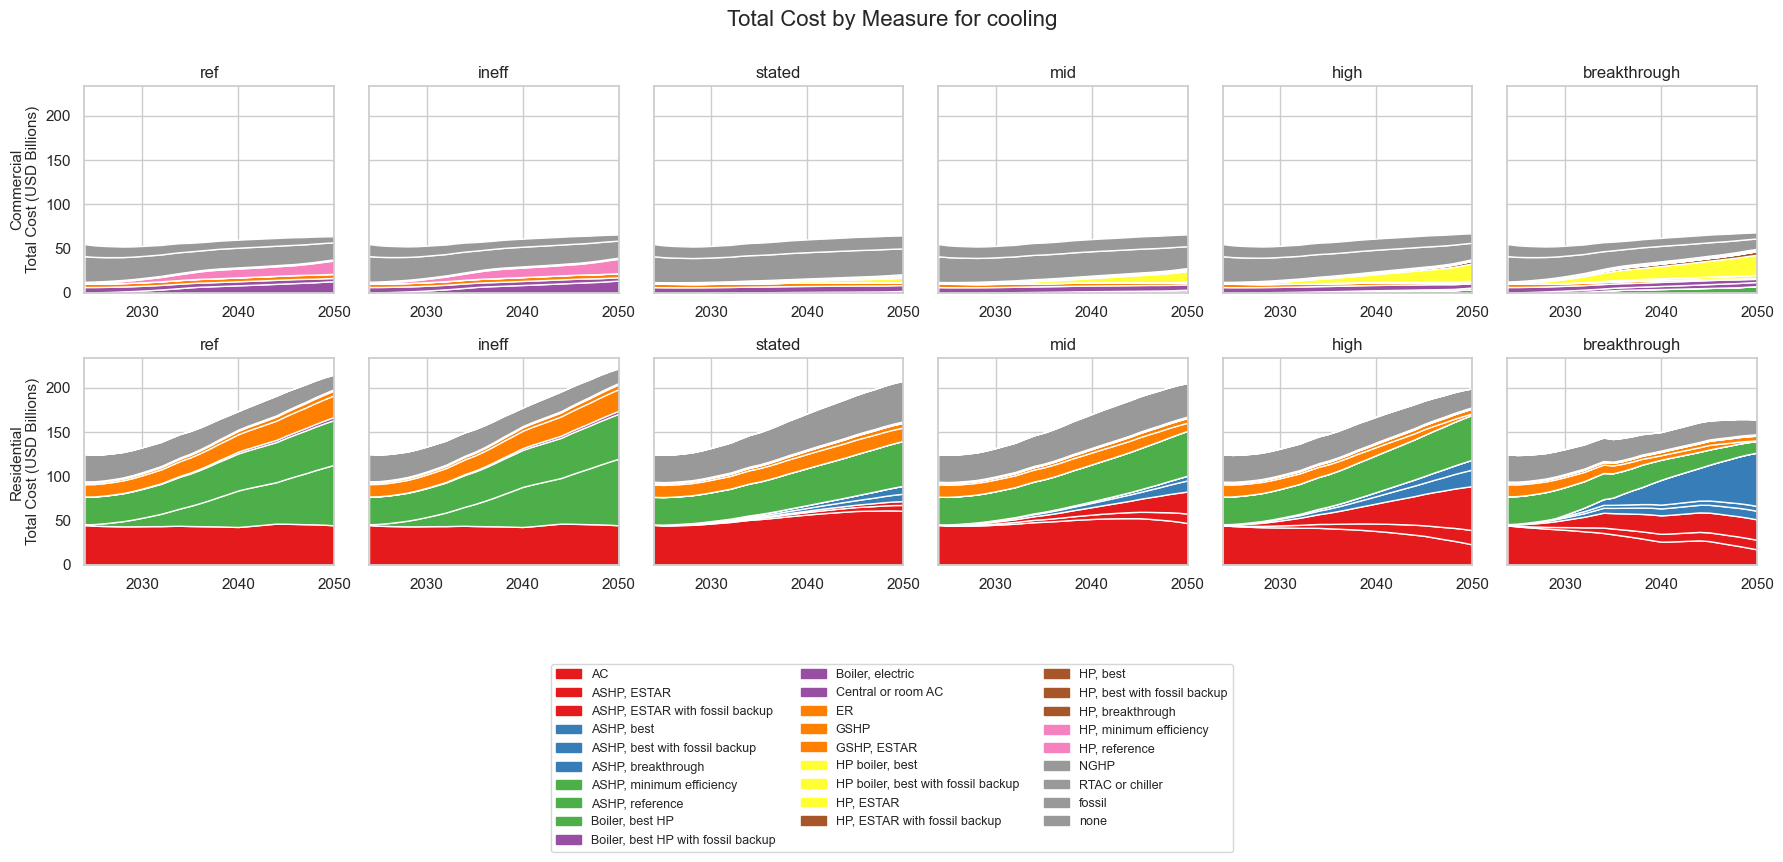

In [179]:
combined_df_heating = combined_df[combined_df['end_use'].isin(['Cooling (Equip.)'])]
plot_enduses(combined_df_heating, 'cooling')

C:\Users\vapeu\AppData\Local\Temp\ipykernel_10896\3005769342.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set1', len(measures))


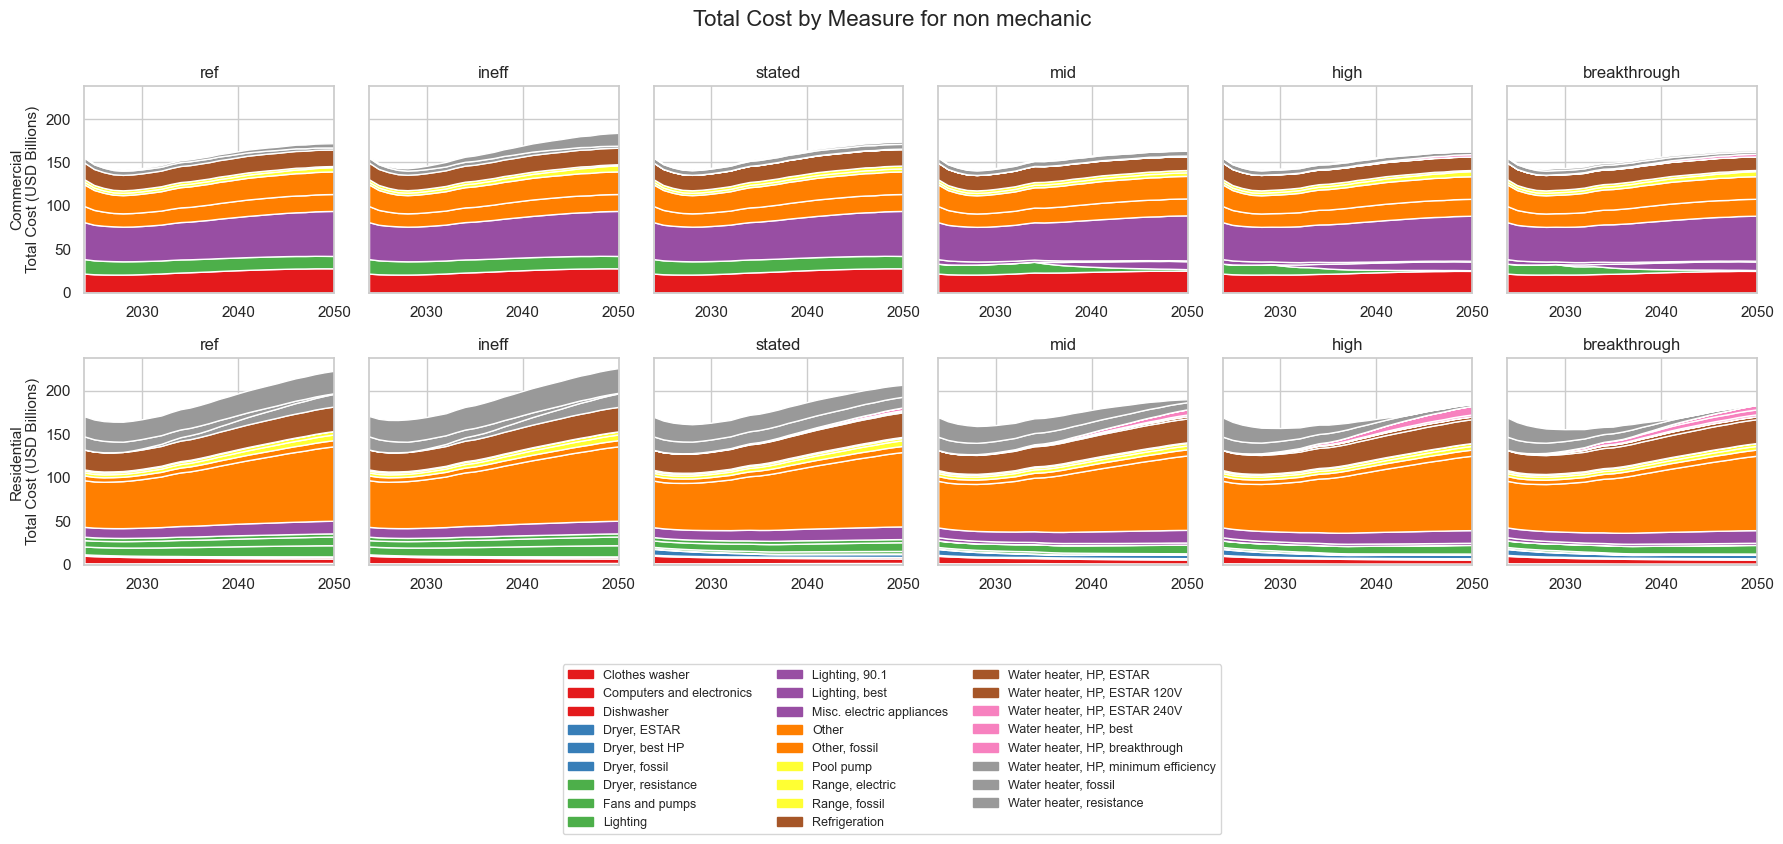

In [180]:
combined_df_non_mechanic = combined_df[~combined_df['end_use'].isin(['Heating (Equip.)', 'Cooling (Equip.)', 'Ventilation'])]
plot_enduses(combined_df_non_mechanic, 'non mechanic')

# Spatial mapping

## read unit equipment from scout result json file

In [6]:
with open("scout_results/ineff.json") as f:
    data = json.load(f)

In [7]:
def extract_measure_stock(json_data):
    records = []
    for measure_name, measure_data in json_data.items():
        if 'on-site generation' in measure_name.lower():
            continue  
        max_adoption = measure_data["Markets and Savings (by Category)"]["Max adoption potential"]
        if measure_name.startswith("(C)"):
            # TBtu served case for commercial
            stock_data_key = next((k for k in max_adoption.keys() if "Measure Stock" in k and "TBtu" in k), None)
            if not stock_data_key:
                continue  # skip if no matching key found
            stock_data = max_adoption[stock_data_key]
            for state, state_data in stock_data.items():
                for com_type in ["Commercial (New)", "Commercial (Existing)"]:
                    if com_type not in state_data:
                        continue
                    com_data = state_data[com_type]
                    for end_use, end_use_data in com_data.items():
                        if isinstance(end_use_data, dict):
                            for subcat, value in end_use_data.items():
                                # Handle one more nested level (e.g., "Electric")
                                if isinstance(value, dict) and all(str(k).isdigit() for k in value):
                                    for year, v in value.items():
                                        records.append({
                                            "Measure": measure_name,
                                            "Sector": "Commercial",
                                            "Category": com_type,
                                            "State": state,
                                            "End Use": end_use,
                                            "Fuel": subcat,
                                            "Year": int(year),
                                            "Value": v
                                        })
                                elif str(subcat).isdigit():  # No sub-layer
                                    records.append({
                                        "Measure": measure_name,
                                        "Sector": "Commercial",
                                        "Category": com_type,
                                        "State": state,
                                        "End Use": end_use,
                                        "Fuel": "Unknown",
                                        "Year": int(subcat),
                                        "Value": value
                                    })
        elif measure_name.startswith("(R)"):
            # units equipment case for residential
            stock_data = max_adoption.get("Measure Stock (units equipment)", {})
            for state, state_data in stock_data.items():
                for res_type in ["Residential (New)", "Residential (Existing)"]:
                    if res_type not in state_data:
                        continue
                    res_data = state_data[res_type]
                    for end_use, end_use_data in res_data.items():
                        if isinstance(end_use_data, dict):
                            for subcat, value in end_use_data.items():
                                if isinstance(value, dict) and all(str(k).isdigit() for k in value):
                                    for year, v in value.items():
                                        records.append({
                                            "Measure": measure_name,
                                            "Sector": "Residential",
                                            "Category": res_type,
                                            "State": state,
                                            "End Use": end_use,
                                            "Fuel": subcat,
                                            "Year": int(year),
                                            "Value": v
                                        })
                                elif str(subcat).isdigit():  # No sub-layer
                                    records.append({
                                        "Measure": measure_name,
                                        "Sector": "Residential",
                                        "Category": res_type,
                                        "State": state,
                                        "End Use": end_use,
                                        "Fuel": "Unknown",
                                        "Year": int(subcat),
                                        "Value": value
                                    })
    return pd.DataFrame(records)



In [8]:
measure_df = extract_measure_stock(data)

In [9]:
measure_df_total = (
    measure_df
    .assign(Category="Residential")  # optional, if you want to keep it as a single label
    .groupby(["Measure", "Sector", "State", "End Use", "Fuel", "Year"], as_index=False)
    .agg({"Value": "sum"})
)

In [10]:
measure_df.shape

(373086, 8)

In [11]:
measure_df.head(2)

Measure       Sector           Category State End Use  \
0  (R) Ref. Case Gas Dryer  Residential  Residential (New)    AL   Other   
1  (R) Ref. Case Gas Dryer  Residential  Residential (New)    AL   Other   

           Fuel  Year        Value  
0  Non-Electric  2024   709.492284  
1  Non-Electric  2025  1484.786525

In [12]:
measure_df_total

Measure       Sector State  \
0         (C) Min. Efficiency HP FS (NG Furnace)   Commercial    AL   
1         (C) Min. Efficiency HP FS (NG Furnace)   Commercial    AL   
2         (C) Min. Efficiency HP FS (NG Furnace)   Commercial    AL   
3         (C) Min. Efficiency HP FS (NG Furnace)   Commercial    AL   
4         (C) Min. Efficiency HP FS (NG Furnace)   Commercial    AL   
...                                          ...          ...   ...   
186538  (R) Ref. Case Secondary Electric Heating  Residential    WY   
186539  (R) Ref. Case Secondary Electric Heating  Residential    WY   
186540  (R) Ref. Case Secondary Electric Heating  Residential    WY   
186541  (R) Ref. Case Secondary Electric Heating  Residential    WY   
186542  (R) Ref. Case Secondary Electric Heating  Residential    WY   

                 End Use      Fuel  Year  Value  
0       Cooling (Equip.)  Electric  2024    0.0  
1       Cooling (Equip.)  Electric  2025    0.0  
2       Cooling (Equip.)  Electric  2026    0.0  
3       Cooling (Equip.)  Electric  2027    0.0  
4       Cooling (Equip.)  Electric  2028    0.0  
...                  ...       ...   ...    ...  
186538  Heating (Equip.)  Electric  2046    0.0  
186539  Heating (Equip.)  Electric  2047    0.0  
186540  Heating (Equip.)  Electric  2048    0.0  
186541  Heating (Equip.)  Electric  2049    0.0  
186542  Heating (Equip.)  Electric  2050    0.0  

[186543 rows x 7 columns]

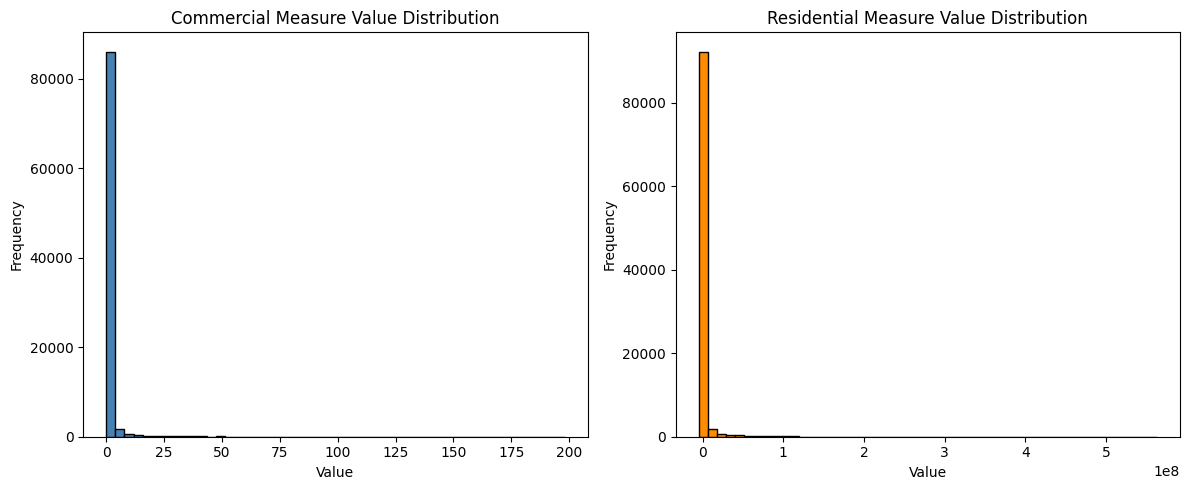

In [13]:

# Separate the data
commercial_values = measure_df_total[measure_df_total['Sector'] == 'Commercial']['Value']
residential_values = measure_df_total[measure_df_total['Sector'] == 'Residential']['Value']

# Plot
plt.figure(figsize=(12, 5))

# Commercial
plt.subplot(1, 2, 1)
plt.hist(commercial_values, bins=50, color='steelblue', edgecolor='black')
plt.title("Commercial Measure Value Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Residential
plt.subplot(1, 2, 2)
plt.hist(residential_values, bins=50, color='darkorange', edgecolor='black')
plt.title("Residential Measure Value Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

## read normalization factor

In [14]:
with open('mseg_res_com_state/mseg_res_com_state.json') as f:
    data = json.load(f)

records = []


for state, sectors in data.items():
    for home_type, values in sectors.items():
        if 'total homes' in values:
            yearly_data = values['total homes']
            record = {
                'state': state,
                'home_type': home_type,
                'sector': 'Residential',
                'type': 'total homes'
            }
        elif 'total square footage' in values:
            yearly_data = values['total square footage']
            yearly_data = {year: val * 1e6 for year, val in yearly_data.items()} # convert total square footage to million
            record = {
                'state': state,
                'home_type': home_type,
                'sector': 'Commercial',
                'type': 'total square footage'
            }
        else:
            continue

        # Add yearly data to the record
        for year, val in yearly_data.items():
            record[year] = val

        records.append(record)

normalizer = pd.DataFrame(records)
normalizer.head()

state           home_type       sector                  type           2015  \
0    AK  single family home  Residential           total homes  165145.225898   
1    AK   multi family home  Residential           total homes   75049.421600   
2    AK         mobile home  Residential           total homes   11011.112429   
3    AK            assembly   Commercial  total square footage            NaN   
4    AK           education   Commercial  total square footage            NaN   

           2016          2017          2018          2019          2020  ...  \
0  1.662951e+05  1.675481e+05  1.688372e+05  1.701527e+05  1.716532e+05  ...   
1  7.554866e+04  7.598085e+04  7.644780e+04  7.696176e+04  7.745732e+04  ...   
2  1.090214e+04  1.080764e+04  1.071782e+04  1.062776e+04  1.053884e+04  ...   
3  4.632158e+07  4.644994e+07  4.658048e+07  4.679352e+07  4.708650e+07  ...   
4  4.174184e+07  4.200300e+07  4.234672e+07  4.273145e+07  4.327324e+07  ...   

           2041          2042          2043          2044          2045  \
0  2.005349e+05  2.017796e+05  2.030186e+05  2.042551e+05  2.054897e+05   
1  8.843769e+04  8.890523e+04  8.936761e+04  8.982363e+04  9.027509e+04   
2  9.492755e+03  9.450621e+03  9.409569e+03  9.369051e+03  9.328983e+03   
3  5.380055e+07  5.398811e+07  5.417278e+07  5.435865e+07  5.454867e+07   
4  5.279113e+07  5.311387e+07  5.343548e+07  5.375994e+07  5.409024e+07   

           2046          2047          2048          2049          2050  
0  2.067171e+05  2.079353e+05  2.091394e+05  2.103259e+05  2.114978e+05  
1  9.072187e+04  9.117455e+04  9.162595e+04  9.207924e+04  9.253528e+04  
2  9.288563e+03  9.249605e+03  9.211491e+03  9.173643e+03  9.136920e+03  
3  5.474489e+07  5.494819e+07  5.515871e+07  5.537600e+07  5.559900e+07  
4  5.442844e+07  5.477547e+07  5.513155e+07  5.549629e+07  5.586872e+07  

[5 rows x 40 columns]

In [15]:
# Select only year columns (they are strings like "2015", "2016", etc.)
year_cols = [col for col in normalizer.columns if col.isdigit()]

# Group by state, sector, and type; sum over years
grouped_normalizer = normalizer.groupby(['state', 'sector', 'type'])[year_cols].sum().reset_index()

# Melt grouped_normalizer: from wide to long
normalizer_long = grouped_normalizer.melt(
    id_vars=['state', 'sector', 'type'],
    var_name='year',
    value_name='normalizer_value'
)
normalizer_long['year'] = normalizer_long['year'].astype(int)
normalizer_long = normalizer_long.rename(columns={'normalizer_value': 'total house or sqft'})
normalizer_long.head()

state       sector                  type  year  total house or sqft
0    AK   Commercial  total square footage  2015         0.000000e+00
1    AK  Residential           total homes  2015         2.512058e+05
2    AL   Commercial  total square footage  2015         0.000000e+00
3    AL  Residential           total homes  2015         1.852935e+06
4    AR   Commercial  total square footage  2015         0.000000e+00

In [16]:
measure_df_total.head()

Measure      Sector State           End Use  \
0  (C) Min. Efficiency HP FS (NG Furnace)  Commercial    AL  Cooling (Equip.)   
1  (C) Min. Efficiency HP FS (NG Furnace)  Commercial    AL  Cooling (Equip.)   
2  (C) Min. Efficiency HP FS (NG Furnace)  Commercial    AL  Cooling (Equip.)   
3  (C) Min. Efficiency HP FS (NG Furnace)  Commercial    AL  Cooling (Equip.)   
4  (C) Min. Efficiency HP FS (NG Furnace)  Commercial    AL  Cooling (Equip.)   

       Fuel  Year  Value  
0  Electric  2024    0.0  
1  Electric  2025    0.0  
2  Electric  2026    0.0  
3  Electric  2027    0.0  
4  Electric  2028    0.0

In [17]:
measure_df_res = measure_df_total[measure_df_total['Sector']=='Residential']
print(measure_df_res.shape)
measure_df_res.head()

(96579, 7)


Measure       Sector State  \
89964  (R) Min. Efficiency ASHP FS (NG Furnace)  Residential    AL   
89965  (R) Min. Efficiency ASHP FS (NG Furnace)  Residential    AL   
89966  (R) Min. Efficiency ASHP FS (NG Furnace)  Residential    AL   
89967  (R) Min. Efficiency ASHP FS (NG Furnace)  Residential    AL   
89968  (R) Min. Efficiency ASHP FS (NG Furnace)  Residential    AL   

                End Use      Fuel  Year  Value  
89964  Cooling (Equip.)  Electric  2024    0.0  
89965  Cooling (Equip.)  Electric  2025    0.0  
89966  Cooling (Equip.)  Electric  2026    0.0  
89967  Cooling (Equip.)  Electric  2027    0.0  
89968  Cooling (Equip.)  Electric  2028    0.0

In [18]:
normalizer_long.head()

state       sector                  type  year  total house or sqft
0    AK   Commercial  total square footage  2015         0.000000e+00
1    AK  Residential           total homes  2015         2.512058e+05
2    AL   Commercial  total square footage  2015         0.000000e+00
3    AL  Residential           total homes  2015         1.852935e+06
4    AR   Commercial  total square footage  2015         0.000000e+00

In [19]:
normalizer_long.shape

(3672, 5)

In [20]:
measure_df_res = measure_df_res.merge(
    normalizer_long,
    left_on=['State', 'Sector','Year'],
    right_on=['state', 'sector','year'],
    how='left'
)

# Step 3: Drop duplicate columns if needed
print(measure_df_res.shape)
measure_df_res

(96579, 12)


Measure       Sector State  \
0      (R) Min. Efficiency ASHP FS (NG Furnace)  Residential    AL   
1      (R) Min. Efficiency ASHP FS (NG Furnace)  Residential    AL   
2      (R) Min. Efficiency ASHP FS (NG Furnace)  Residential    AL   
3      (R) Min. Efficiency ASHP FS (NG Furnace)  Residential    AL   
4      (R) Min. Efficiency ASHP FS (NG Furnace)  Residential    AL   
...                                         ...          ...   ...   
96574  (R) Ref. Case Secondary Electric Heating  Residential    WY   
96575  (R) Ref. Case Secondary Electric Heating  Residential    WY   
96576  (R) Ref. Case Secondary Electric Heating  Residential    WY   
96577  (R) Ref. Case Secondary Electric Heating  Residential    WY   
96578  (R) Ref. Case Secondary Electric Heating  Residential    WY   

                End Use      Fuel  Year  Value state       sector  \
0      Cooling (Equip.)  Electric  2024    0.0    AL  Residential   
1      Cooling (Equip.)  Electric  2025    0.0    AL  Residential   
2      Cooling (Equip.)  Electric  2026    0.0    AL  Residential   
3      Cooling (Equip.)  Electric  2027    0.0    AL  Residential   
4      Cooling (Equip.)  Electric  2028    0.0    AL  Residential   
...                 ...       ...   ...    ...   ...          ...   
96574  Heating (Equip.)  Electric  2046    0.0    WY  Residential   
96575  Heating (Equip.)  Electric  2047    0.0    WY  Residential   
96576  Heating (Equip.)  Electric  2048    0.0    WY  Residential   
96577  Heating (Equip.)  Electric  2049    0.0    WY  Residential   
96578  Heating (Equip.)  Electric  2050    0.0    WY  Residential   

              type  year  total house or sqft  
0      total homes  2024         2.031115e+06  
1      total homes  2025         2.051576e+06  
2      total homes  2026         2.071939e+06  
3      total homes  2027         2.092353e+06  
4      total homes  2028         2.112855e+06  
...            ...   ...                  ...  
96574  total homes  2046         3.209951e+05  
96575  total homes  2047         3.245547e+05  
96576  total homes  2048         3.280988e+05  
96577  total homes  2049         3.316248e+05  
96578  total homes  2050         3.351412e+05  

[96579 rows x 12 columns]

In [21]:
measure_df_res['mes_percent'] = measure_df_res['Value']/measure_df_res['total house or sqft']
measure_df_res

Measure       Sector State  \
0      (R) Min. Efficiency ASHP FS (NG Furnace)  Residential    AL   
1      (R) Min. Efficiency ASHP FS (NG Furnace)  Residential    AL   
2      (R) Min. Efficiency ASHP FS (NG Furnace)  Residential    AL   
3      (R) Min. Efficiency ASHP FS (NG Furnace)  Residential    AL   
4      (R) Min. Efficiency ASHP FS (NG Furnace)  Residential    AL   
...                                         ...          ...   ...   
96574  (R) Ref. Case Secondary Electric Heating  Residential    WY   
96575  (R) Ref. Case Secondary Electric Heating  Residential    WY   
96576  (R) Ref. Case Secondary Electric Heating  Residential    WY   
96577  (R) Ref. Case Secondary Electric Heating  Residential    WY   
96578  (R) Ref. Case Secondary Electric Heating  Residential    WY   

                End Use      Fuel  Year  Value state       sector  \
0      Cooling (Equip.)  Electric  2024    0.0    AL  Residential   
1      Cooling (Equip.)  Electric  2025    0.0    AL  Residential   
2      Cooling (Equip.)  Electric  2026    0.0    AL  Residential   
3      Cooling (Equip.)  Electric  2027    0.0    AL  Residential   
4      Cooling (Equip.)  Electric  2028    0.0    AL  Residential   
...                 ...       ...   ...    ...   ...          ...   
96574  Heating (Equip.)  Electric  2046    0.0    WY  Residential   
96575  Heating (Equip.)  Electric  2047    0.0    WY  Residential   
96576  Heating (Equip.)  Electric  2048    0.0    WY  Residential   
96577  Heating (Equip.)  Electric  2049    0.0    WY  Residential   
96578  Heating (Equip.)  Electric  2050    0.0    WY  Residential   

              type  year  total house or sqft  mes_percent  
0      total homes  2024         2.031115e+06          0.0  
1      total homes  2025         2.051576e+06          0.0  
2      total homes  2026         2.071939e+06          0.0  
3      total homes  2027         2.092353e+06          0.0  
4      total homes  2028         2.112855e+06          0.0  
...            ...   ...                  ...          ...  
96574  total homes  2046         3.209951e+05          0.0  
96575  total homes  2047         3.245547e+05          0.0  
96576  total homes  2048         3.280988e+05          0.0  
96577  total homes  2049         3.316248e+05          0.0  
96578  total homes  2050         3.351412e+05          0.0  

[96579 rows x 13 columns]

In [22]:
# Group and sum mes_percent
mes_percent_sum_df = (
    measure_df_res
    .groupby(['State', 'Year'])['mes_percent']
    .sum()
    .reset_index()
    .rename(columns={'mes_percent': 'sum_mes_percent'})
)
mes_percent_sum_df

State  Year  sum_mes_percent
0       AL  2024         7.514578
1       AL  2025        14.973628
2       AL  2026        22.300672
3       AL  2027        29.483538
4       AL  2028        36.845740
...    ...   ...              ...
1318    WY  2046        69.516940
1319    WY  2047        69.563605
1320    WY  2048        70.115011
1321    WY  2049        70.176834
1322    WY  2050        70.238216

[1323 rows x 3 columns]

In [23]:
min_val = mes_percent_sum_df['sum_mes_percent'].min()
max_val = mes_percent_sum_df['sum_mes_percent'].max()

print(f"Range of sum_mes_percent: {min_val:.6f} to {max_val:.6f}")

Range of sum_mes_percent: 5.816223 to 76.057560


<Axes: >

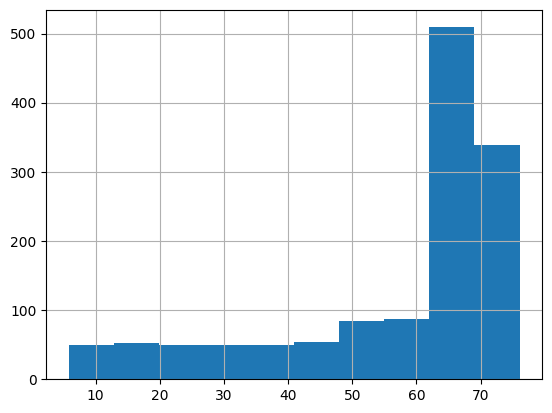

In [24]:
mes_percent_sum_df['sum_mes_percent'].hist()

## mapping

In [25]:
filtered = cost_all_scenario[
    cost_all_scenario['metric'].isin(['Energy Cost Savings (USD)'])
]
combined_df = pd.concat([filtered, ref_case], ignore_index=True)

In [26]:
measure_map = pd.read_csv('map_meas/measure_map.tsv', sep='\t')
combined_df = combined_df.merge(
    measure_map[['meas', 'measure_desc_simple']],
    on='meas',
    how='left'
)
# Group bldg_type → sector
combined_df['sector'] = combined_df['bldg_type'].str.extract(r'(Residential|Commercial)')
combined_df = combined_df[combined_df['scenario']!='ref']

In [27]:
us_states = pd.read_csv('https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv')
us_states.columns = ['name', 'reg']

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

In [ ]:
name = 'red_white_green'
if name not in plt.colormaps():
    red_white_green = LinearSegmentedColormap.from_list(
        name,
        ['tab:red', 'white', 'tab:green']
    )
    plt.colormaps.register(name=name, cmap=red_white_green)


In [54]:
combined_df.head(2)

meas            adoption_scn                     metric  \
0  (R) Ref. Case Gas Dryer  Max adoption potential  Energy Cost Savings (USD)   
1  (R) Ref. Case Gas Dryer  Max adoption potential  Energy Cost Savings (USD)   

  reg          bldg_type end_use          fuel  year  value scenario  \
0  AL  Residential (New)   Other  Non-Electric  2024    0.0    ineff   
1  AL  Residential (New)   Other  Non-Electric  2025    0.0    ineff   

  measure_desc_simple       sector  
0       Dryer, fossil  Residential  
1       Dryer, fossil  Residential

In [46]:
normalizer_long.head(2)

state       sector                  type  year  normalizer_value
0    AK   Commercial  total square footage  2015          0.000000
1    AK  Residential           total homes  2015     251205.759928

In [31]:
# Perform left join on combined_df using sector, region, and year
combined_df = combined_df.merge(
    normalizer_long,
    how='left',
    left_on=['reg', 'sector', 'year'],
    right_on=['state', 'sector', 'year']
)

# Drop the redundant 'state' column
combined_df = combined_df.drop(columns=['state'])

combined_df.head()

meas            adoption_scn                     metric  \
0  (R) Ref. Case Gas Dryer  Max adoption potential  Energy Cost Savings (USD)   
1  (R) Ref. Case Gas Dryer  Max adoption potential  Energy Cost Savings (USD)   
2  (R) Ref. Case Gas Dryer  Max adoption potential  Energy Cost Savings (USD)   
3  (R) Ref. Case Gas Dryer  Max adoption potential  Energy Cost Savings (USD)   
4  (R) Ref. Case Gas Dryer  Max adoption potential  Energy Cost Savings (USD)   

  reg          bldg_type end_use          fuel  year  value scenario  \
0  AL  Residential (New)   Other  Non-Electric  2024    0.0    ineff   
1  AL  Residential (New)   Other  Non-Electric  2025    0.0    ineff   
2  AL  Residential (New)   Other  Non-Electric  2026    0.0    ineff   
3  AL  Residential (New)   Other  Non-Electric  2027    0.0    ineff   
4  AL  Residential (New)   Other  Non-Electric  2028    0.0    ineff   

  measure_desc_simple       sector         type  total house or sqft  
0       Dryer, fossil  Residential  total homes         2.031115e+06  
1       Dryer, fossil  Residential  total homes         2.051576e+06  
2       Dryer, fossil  Residential  total homes         2.071939e+06  
3       Dryer, fossil  Residential  total homes         2.092353e+06  
4       Dryer, fossil  Residential  total homes         2.112855e+06

In [32]:
combined_df['cost_savings_normalized'] = combined_df['value']/combined_df['total house or sqft']

KeyError: 'normalizer_value'

0         7.514578
1        14.973628
2        22.300672
3        29.483538
4        36.845740
           ...    
96574    69.516940
96575    69.563605
96576    70.115011
96577    70.176834
96578    70.238216
Name: mes_percent, Length: 96579, dtype: float64

In [158]:
sorted_mes_percent

93927    -0.701252
93926    -0.667509
93608    -0.653016
93925    -0.633340
93607    -0.624767
           ...    
54886    36.472989
54887    36.553808
54888    36.632594
54889    36.709455
54890    36.784605
Name: mes_percent, Length: 59529, dtype: float64

In [159]:
measure_df_res[measure_df_res['mes_percent'] < 0]

Measure       Sector State        End Use  \
16948  (R) Min. Efficiency HPWH FS  Residential    ME  Water Heating   
16949  (R) Min. Efficiency HPWH FS  Residential    ME  Water Heating   
16950  (R) Min. Efficiency HPWH FS  Residential    ME  Water Heating   
16951  (R) Min. Efficiency HPWH FS  Residential    ME  Water Heating   
16952  (R) Min. Efficiency HPWH FS  Residential    ME  Water Heating   
...                            ...          ...   ...            ...   
93925  (R) Ref. Case Resist. WH FS  Residential    WY  Water Heating   
93926  (R) Ref. Case Resist. WH FS  Residential    WY  Water Heating   
93927  (R) Ref. Case Resist. WH FS  Residential    WY  Water Heating   
93928  (R) Ref. Case Resist. WH FS  Residential    WY  Water Heating   
93929  (R) Ref. Case Resist. WH FS  Residential    WY  Water Heating   

               Fuel  Year          Value state       sector         type  \
16948  Non-Electric  2043   -6531.074911    ME  Residential  total homes   
16949  Non-Electric  2044  -27495.589689    ME  Residential  total homes   
16950  Non-Electric  2045  -31702.984388    ME  Residential  total homes   
16951  Non-Electric  2046  -31593.291442    ME  Residential  total homes   
16952  Non-Electric  2047  -24864.686653    ME  Residential  total homes   
...             ...   ...            ...   ...          ...          ...   
93925  Non-Electric  2043 -196532.505943    WY  Residential  total homes   
93926  Non-Electric  2044 -209516.521087    WY  Residential  total homes   
93927  Non-Electric  2045 -222607.693267    WY  Residential  total homes   
93928  Non-Electric  2046 -149362.251892    WY  Residential  total homes   
93929  Non-Electric  2047 -157976.685148    WY  Residential  total homes   

       year  total house or sqft  mes_percent  
16948  2043        635610.017066    -0.010275  
16949  2044        638338.753011    -0.043074  
16950  2045        641019.407185    -0.049457  
16951  2046        643644.156759    -0.049085  
16952  2047        646237.901223    -0.038476  
...     ...                  ...          ...  
93925  2043        310311.215619    -0.633340  
93926  2044        313877.984850    -0.667509  
93927  2045        317443.009769    -0.701252  
93928  2046        320995.101860    -0.465310  
93929  2047        324554.694493    -0.486749  

[1252 rows x 13 columns]

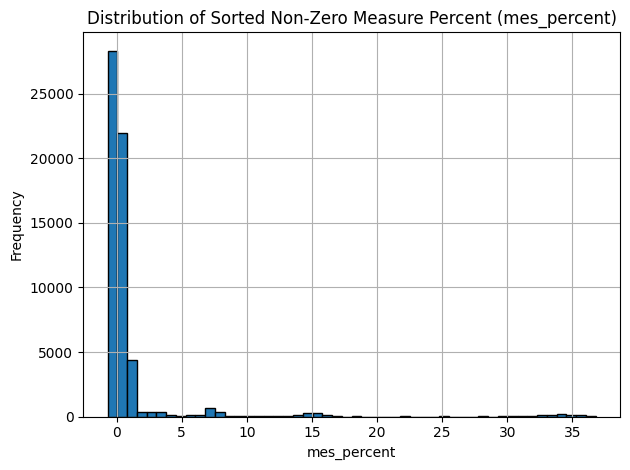

In [157]:
# Filter and sort the values
sorted_mes_percent = (
    measure_df_res[measure_df_res['mes_percent'] != 0]
    .sort_values(by='mes_percent')['mes_percent']
)

# Plot histogram
sorted_mes_percent.hist(bins=50, edgecolor='black')

plt.title("Distribution of Sorted Non-Zero Measure Percent (mes_percent)")
plt.xlabel("mes_percent")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [182]:
measure_df_res.head(2)

Measure       Sector State  \
0  (R) Min. Efficiency ASHP FS (NG Furnace)  Residential    AL   
1  (R) Min. Efficiency ASHP FS (NG Furnace)  Residential    AL   

            End Use      Fuel  Year  Value state       sector         type  \
0  Cooling (Equip.)  Electric  2024    0.0    AL  Residential  total homes   
1  Cooling (Equip.)  Electric  2025    0.0    AL  Residential  total homes   

   year  total house or sqft  mes_percent  
0  2024         2.031115e+06          0.0  
1  2025         2.051576e+06          0.0

In [189]:
combined_df.head(2)

meas            adoption_scn                     metric  \
0  (R) Ref. Case Gas Dryer  Max adoption potential  Energy Cost Savings (USD)   
1  (R) Ref. Case Gas Dryer  Max adoption potential  Energy Cost Savings (USD)   

  reg          bldg_type end_use          fuel  year  value scenario  \
0  AL  Residential (New)   Other  Non-Electric  2024    0.0    ineff   
1  AL  Residential (New)   Other  Non-Electric  2025    0.0    ineff   

  measure_desc_simple       sector         type  normalizer_value  \
0       Dryer, fossil  Residential  total homes      2.031115e+06   
1       Dryer, fossil  Residential  total homes      2.051576e+06   

   cost_savings_normalized  
0                      0.0  
1                      0.0

In [190]:
combined_df_new = combined_df[['meas', 'reg', 'end_use', 'fuel', 'year', 'value','scenario', 'measure_desc_simple', 'sector','normalizer_value']]
combined_df_new.head(2)

meas reg end_use          fuel  year  value scenario  \
0  (R) Ref. Case Gas Dryer  AL   Other  Non-Electric  2024    0.0    ineff   
1  (R) Ref. Case Gas Dryer  AL   Other  Non-Electric  2025    0.0    ineff   

  measure_desc_simple       sector  normalizer_value  
0       Dryer, fossil  Residential      2.031115e+06  
1       Dryer, fossil  Residential      2.051576e+06

In [191]:
combined_df_new = combined_df_new.merge(
    measure_df_res[['Measure', 'Sector', 'State', 'End Use', 'Fuel', 'year', 'mes_percent']],
    left_on=['meas', 'sector', 'reg', 'end_use', 'fuel', 'year'],
    right_on=['Measure', 'Sector', 'State', 'End Use', 'Fuel', 'year'],
    how='left',
    suffixes=('', '_drop')  # left columns stay unchanged
)
combined_df_new = combined_df_new.drop(columns=[col for col in combined_df_new.columns if col.endswith('_drop')])


In [203]:
combined_df_new[combined_df_new['value']!=0]

meas reg  \
97902    (R) Min. Efficiency ASHP FS (Other Fossil Furn...  AL   
97903    (R) Min. Efficiency ASHP FS (Other Fossil Furn...  AL   
97904    (R) Min. Efficiency ASHP FS (Other Fossil Furn...  AL   
97905    (R) Min. Efficiency ASHP FS (Other Fossil Furn...  AL   
97906    (R) Min. Efficiency ASHP FS (Other Fossil Furn...  AL   
...                                                    ...  ..   
8754286                  (C) ES HP FS (RTU, NG Ht.) & Env.  WY   
8754287                  (C) ES HP FS (RTU, NG Ht.) & Env.  WY   
8754288                  (C) ES HP FS (RTU, NG Ht.) & Env.  WY   
8754289                  (C) ES HP FS (RTU, NG Ht.) & Env.  WY   
8754290                  (C) ES HP FS (RTU, NG Ht.) & Env.  WY   

                  end_use      fuel  year         value      scenario  \
97902    Heating (Equip.)  Electric  2024 -7.138599e+05         ineff   
97903    Heating (Equip.)  Electric  2024 -7.138599e+05         ineff   
97904    Heating (Equip.)  Electric  2025 -1.449958e+06         ineff   
97905    Heating (Equip.)  Electric  2025 -1.449958e+06         ineff   
97906    Heating (Equip.)  Electric  2026 -2.174017e+06         ineff   
...                   ...       ...   ...           ...           ...   
8754286       Ventilation  Electric  2049  2.235460e+05  breakthrough   
8754287       Ventilation  Electric  2049  2.235460e+05  breakthrough   
8754288       Ventilation  Electric  2050  2.301204e+05  breakthrough   
8754289       Ventilation  Electric  2050  2.301204e+05  breakthrough   
8754290       Ventilation  Electric  2050  2.301204e+05  breakthrough   

              measure_desc_simple       sector  normalizer_value  \
97902    ASHP, minimum efficiency  Residential      2.031115e+06   
97903    ASHP, minimum efficiency  Residential      2.031115e+06   
97904    ASHP, minimum efficiency  Residential      2.051576e+06   
97905    ASHP, minimum efficiency  Residential      2.051576e+06   
97906    ASHP, minimum efficiency  Residential      2.071939e+06   
...                           ...          ...               ...   
8754286                 HP, ESTAR   Commercial      3.352752e+08   
8754287                 HP, ESTAR   Commercial      3.352752e+08   
8754288                 HP, ESTAR   Commercial      3.383700e+08   
8754289                 HP, ESTAR   Commercial      3.383700e+08   
8754290                 HP, ESTAR   Commercial      3.383700e+08   

                                                   Measure       Sector State  \
97902    (R) Min. Efficiency ASHP FS (Other Fossil Furn...  Residential    AL   
97903    (R) Min. Efficiency ASHP FS (Other Fossil Furn...  Residential    AL   
97904    (R) Min. Efficiency ASHP FS (Other Fossil Furn...  Residential    AL   
97905    (R) Min. Efficiency ASHP FS (Other Fossil Furn...  Residential    AL   
97906    (R) Min. Efficiency ASHP FS (Other Fossil Furn...  Residential    AL   
...                                                    ...          ...   ...   
8754286                                                NaN          NaN   NaN   
8754287                                                NaN          NaN   NaN   
8754288                                                NaN          NaN   NaN   
8754289                                                NaN          NaN   NaN   
8754290                                                NaN          NaN   NaN   

                  End Use      Fuel  mes_percent  \
97902    Heating (Equip.)  Electric     0.000716   
97903    Heating (Equip.)  Electric     0.000716   
97904    Heating (Equip.)  Electric     0.001520   
97905    Heating (Equip.)  Electric     0.001520   
97906    Heating (Equip.)  Electric     0.002400   
...                   ...       ...          ...   
8754286               NaN       NaN          NaN   
8754287               NaN       NaN          NaN   
8754288               NaN       NaN          NaN   
8754289               NaN       NaN          NaN   
8754290               

In [195]:
combined_df_new['cost_savings_normalized'] = combined_df_new['value']*combined_df_new['mes_percent']*combined_df_new['normalizer_value']


In [208]:
combined_df_new[combined_df_new['cost_savings_normalized']!=0]

meas reg           end_use      fuel  \
2646              (C) Ref. Case, Resist. Heat  AL  Heating (Equip.)  Electric   
2647              (C) Ref. Case, Resist. Heat  AL  Heating (Equip.)  Electric   
2648              (C) Ref. Case, Resist. Heat  AL  Heating (Equip.)  Electric   
2649              (C) Ref. Case, Resist. Heat  AL  Heating (Equip.)  Electric   
2650              (C) Ref. Case, Resist. Heat  AL  Heating (Equip.)  Electric   
...                                       ...  ..               ...       ...   
8793976  (C) Brk. HP FS (NG Frn. AC) & Env.++  WY       Ventilation  Electric   
8793977  (C) Brk. HP FS (NG Frn. AC) & Env.++  WY       Ventilation  Electric   
8793978  (C) Brk. HP FS (NG Frn. AC) & Env.++  WY       Ventilation  Electric   
8793979  (C) Brk. HP FS (NG Frn. AC) & Env.++  WY       Ventilation  Electric   
8793980  (C) Brk. HP FS (NG Frn. AC) & Env.++  WY       Ventilation  Electric   

         year  value      scenario measure_desc_simple      sector  \
2646     2024    0.0         ineff     RTAC or chiller  Commercial   
2647     2024    0.0         ineff                  ER  Commercial   
2648     2024    0.0         ineff     RTAC or chiller  Commercial   
2649     2025   -0.0         ineff     RTAC or chiller  Commercial   
2650     2025   -0.0         ineff                  ER  Commercial   
...       ...    ...           ...                 ...         ...   
8793976  2049   -0.0  breakthrough    HP, breakthrough  Commercial   
8793977  2049   -0.0  breakthrough    HP, breakthrough  Commercial   
8793978  2050   -0.0  breakthrough    HP, breakthrough  Commercial   
8793979  2050   -0.0  breakthrough    HP, breakthrough  Commercial   
8793980  2050   -0.0  breakthrough    HP, breakthrough  Commercial   

         normalizer_value Measure Sector State End Use Fuel  mes_percent  \
2646         1.252361e+09     NaN    NaN   NaN     NaN  NaN          NaN   
2647         1.252361e+09     NaN    NaN   NaN     NaN  NaN          NaN   
2648         1.252361e+09     NaN    NaN   NaN     NaN  NaN          NaN   
2649         1.266473e+09     NaN    NaN   NaN     NaN  NaN          NaN   
2650         1.266473e+09     NaN    NaN   NaN     NaN  NaN          NaN   
...                   ...     ...    ...   ...     ...  ...          ...   
8793976      3.352752e+08     NaN    NaN   NaN     NaN  NaN          NaN   
8793977      3.352752e+08     NaN    NaN   NaN     NaN  NaN          NaN   
8793978      3.383700e+08     NaN    NaN   NaN     NaN  NaN          NaN   
8793979      3.383700e+08     NaN    NaN   NaN     NaN  NaN          NaN   
8793980      3.383700e+08     NaN    NaN   NaN     NaN  NaN          NaN   

         cost_savings_normalized_by_measure  cost_savings_normalized  
2646                                    NaN                      NaN  
2647                                    NaN                      NaN  
2648                                    NaN                      NaN  
2649                                    NaN                      NaN  
2650                                    NaN                      NaN  
...                                     ...                      ...  
8793976                                 NaN                      NaN  
8793977                                 NaN                      NaN  
8793978                                 NaN                      NaN  
8793979                                 NaN                      NaN  
8793980                                 NaN                      NaN  

[7590854 rows x 18 columns]

In [204]:
def generate_map(combined_df, title):
    state_cost = combined_df.groupby(['scenario', 'reg'])['cost_savings_normalized'].sum().reset_index()
    # Merge full state names into cost data
    state_cost = state_cost.merge(us_states, on='reg', how='left')
    
    # Step 3: Merge with geometry
    state_map = gpd.read_file("map_meas/us-states.json")
    state_map = state_map.rename(columns={'name': 'name'})  # ensure column match
    
    # Merge cost with geometry
    merged = state_map.merge(state_cost, on='name')
    
    # Step 4: Plot
    scenarios = ['ref', 'ineff', 'stated', 'mid', 'high', 'breakthrough']
    n = len(scenarios)
    cols = 3
    rows = math.ceil(n / cols)
    
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5*cols, 4*rows))
    axes = axes.flatten()  # to index easily even with 1 row
    # merged['value_billion'] = merged['value'] / 1e9
    # Separate ineff and others
    # data_ineff = merged[merged['scenario'] == 'ineff']
    # data_others = merged[merged['scenario'] != 'ineff']
    
    def get_norm_and_cmap(vmin, vmax):
        if vmin < 0 and vmax > 0:
            return TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax), red_white_green
        elif vmax <= 0:
            return Normalize(vmin=vmin, vmax=vmax), 'Reds_r'
        else:  # vmin >= 0
            return Normalize(vmin=vmin, vmax=vmax), 'Greens'
    
    # Ineff scenario
    # vmin_ineff = data_ineff['cost_savings_normalized'].min()
    # vmax_ineff = data_ineff['cost_savings_normalized'].max()
    # norm_ineff, cmap_ineff = get_norm_and_cmap(vmin_ineff, vmax_ineff)
    
    # # Other scenarios
    # vmin_uniform = data_others['cost_savings_normalized'].min()
    # vmax_uniform = data_others['cost_savings_normalized'].max()
    # norm_uniform, cmap_uniform = get_norm_and_cmap(vmin_uniform, vmax_uniform)
    # use the same color map for all scenarios
    vmin_uniform = merged['cost_savings_normalized'].min()
    vmax_uniform = merged['cost_savings_normalized'].max()
    print(vmin_uniform, vmax_uniform)
    norm_uniform, cmap_uniform = get_norm_and_cmap(vmin_uniform, vmax_uniform)    
    if 'saving' in title.lower():
        # cmap = yellow_white_green
        label = 'Normalized Cost Savings (USD)'
    else:
        # cmap = 'OrRd'
        label = 'Total Cost (Billion USD)'
    for i, scenario in enumerate(scenarios):
        ax = axes[i]  # use flattened axes
    
        data = merged[merged['scenario'] == scenario].copy()
        if data.empty:
            ax.axis('off')
            ax.set_title(f"{scenario.capitalize()} (No data)", fontsize=10, color='gray')
            continue
        # data['value_billion'] = data['value'] / 1e9
        norm = norm_uniform
        cmap = cmap_uniform
        label = 'Normalized Cost Savings (USD)'
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm._A = []
        data.plot(
            column='cost_savings_normalized',
            norm=norm,
            cmap=cmap,
            linewidth=0.5,
            ax=ax,
            edgecolor='0.8',
            legend=True,
            legend_kwds={
                'label': label,
                'shrink': 0.6,
                'ticks': np.linspace(vmin_uniform, vmax_uniform, 6),  # 6 tick marks,
                'format': '%.2f'  # two decimal places
            },
        )
        # Annotate positive and negative values
        # for idx, row in data.iterrows():
        #     centroid = row['geometry'].centroid
        #     value = row['cost_savings_normalized']
        #     if abs(value) > 1e3:  # Avoid cluttering with near-zero labels
        #         ax.annotate(f"{value:,.0f}", (centroid.x, centroid.y), fontsize=7, ha='center', color='black')    
        ax.set_title(scenario.capitalize(), fontsize=12)
        ax.axis('off')

    if 'residential' in title.lower():
        title_norm_explain = '# new homes'
    else:
        title_norm_explain = 'total square footage'

    plt.suptitle(f'Normalized Cost Savings by Scenario for {title} \n Normalized by {title_norm_explain}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'cost_graph/{title} trial.png', transparent=True, bbox_inches='tight')

In [205]:
combined_df_heating['cost_savings_normalized_by_measure']

66256      0.0
66257      0.0
66364     -0.0
66365     -0.0
66472      0.0
          ... 
8396864    NaN
8396971    NaN
8396972    NaN
8397079    NaN
8397080    NaN
Name: cost_savings_normalized_by_measure, Length: 40082, dtype: float64

0.0 0.0


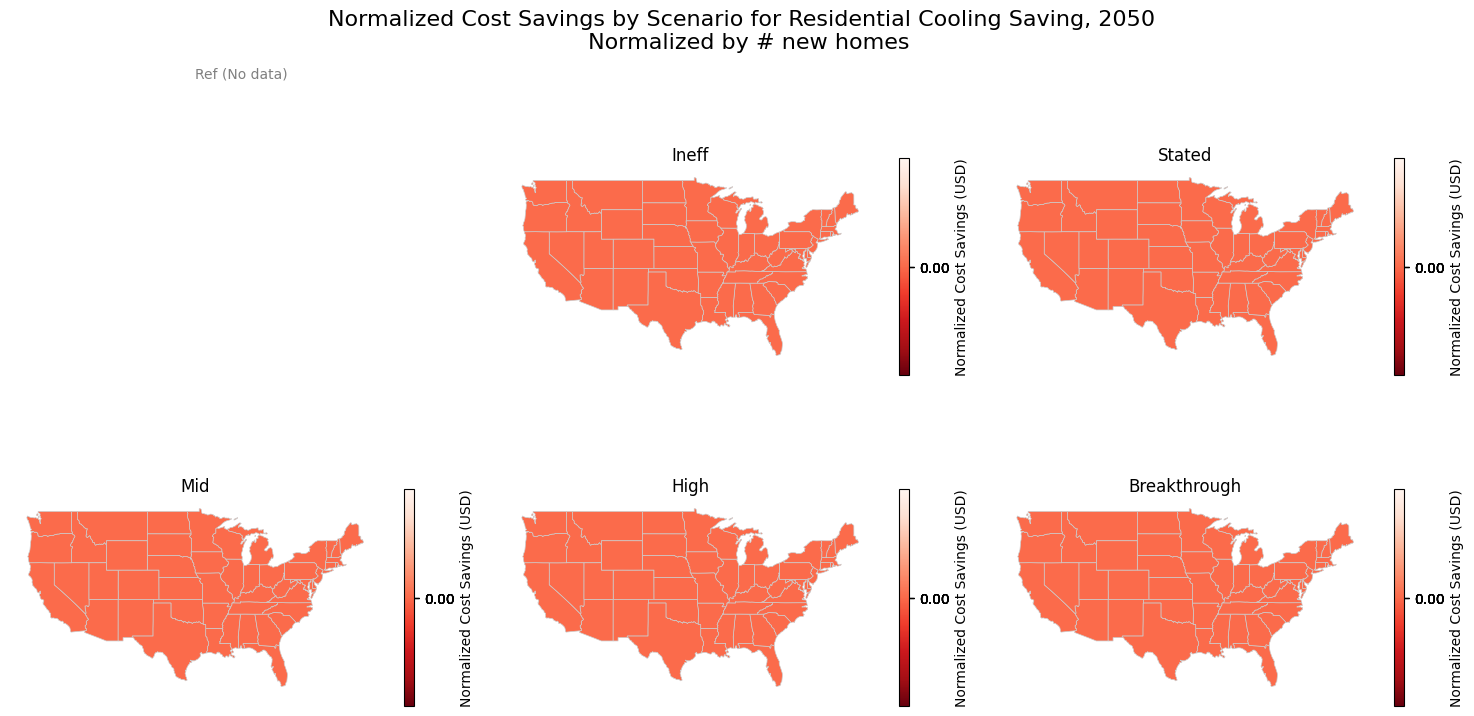

In [206]:
sector = 'Residential'
end_use = 'Cooling (Equip.)'
end_use_for_title = end_use.replace(' (Equip.)', '')
year = 2050
combined_df_heating = combined_df_new[
    (combined_df_new['end_use'] == end_use) &
    (combined_df_new['sector'] == sector) & 
    (combined_df_new['year'] ==year)
]
generate_map(combined_df_heating, f'{sector} {end_use_for_title} Saving, {year}')

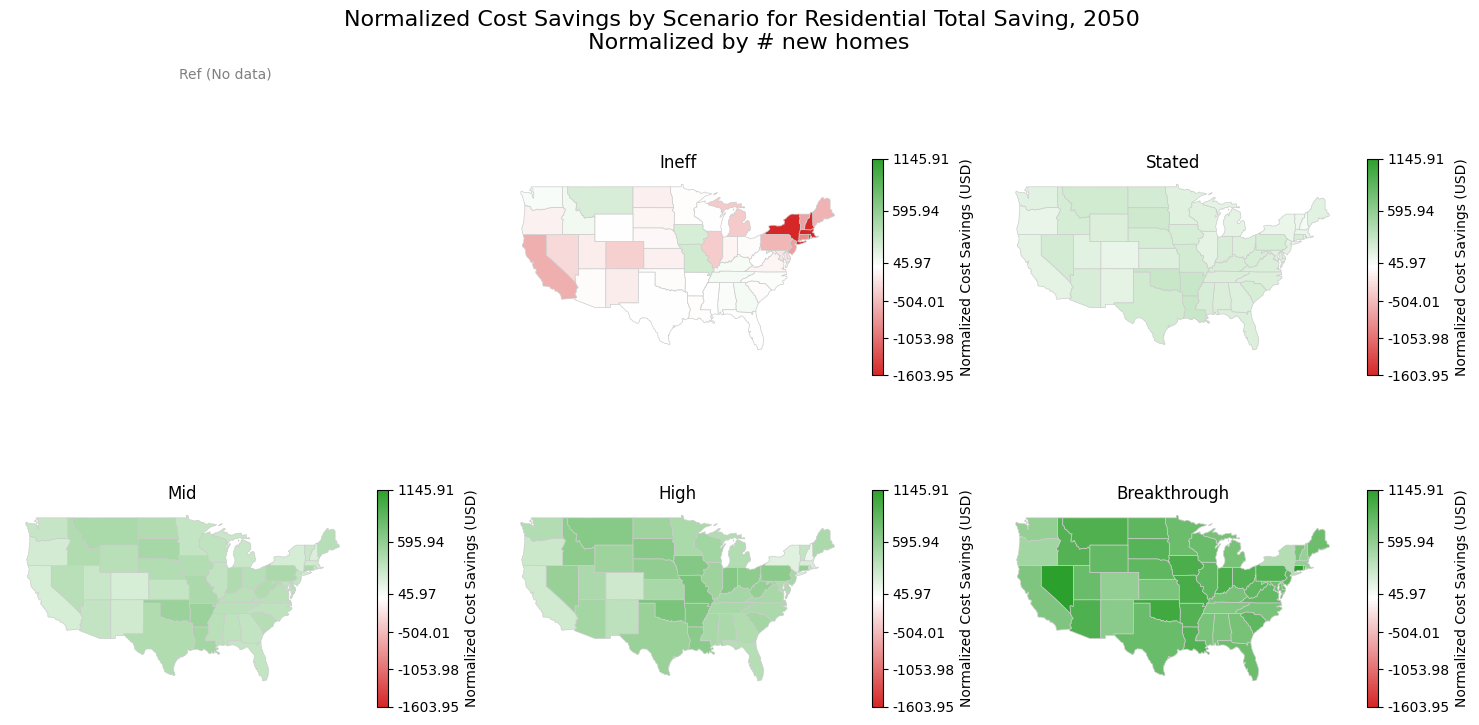

In [81]:
sector = 'Residential'
end_use_for_title = 'Total'
year = 2050
combined_df_heating = combined_df[
    (combined_df['sector'] == sector) & 
    (combined_df['year'] ==year)
]
generate_map(combined_df_heating, f'{sector} {end_use_for_title} Saving, {year}')

## stack plot for saving components

In [45]:
def plot_stacked_cost_savings(df, title):
    bar_width = 0.6
    sub_df = df[df['year'].isin([2030, 2040, 2050])].copy()

    if sub_df.empty:
        print("No data for given state and scenario.")
        return

    # Pivot: rows = year, columns = meas, values = cost_savings_normalized
    pivot_df = sub_df.pivot_table(
        index='year',
        columns='meas',
        values='value',
        aggfunc='sum'
    ).fillna(0)
    meas_totals = pivot_df.sum()
    plotted_measures = meas_totals.abs().sort_values(ascending=False).head(9).index.tolist()
    # Use categorical colormap directly (no need to resample)
    cmap = plt.get_cmap('Pastel1')
    
    # Assign colors to each measure
    colors = {meas: mcolors.to_hex(cmap(i)) for i, meas in enumerate(plotted_measures)}
    color_list = [colors[meas] for meas in plotted_measures]
    
    # Plot
    fig, ax = plt.subplots(figsize=(5,7))

    # Stacked positive
    pivot_df = pivot_df[plotted_measures]
    pivot_df.plot(kind='bar', stacked=True, ax=ax, legend=False, color=color_list, width=bar_width)

    # Label total on top
    totals = pivot_df.sum(axis=1)

    for i, (year, total) in enumerate(totals.items()):
        label = (
            f"${total/1e9:,.0f}B" if abs(total) > 1e9 
            else f"${total/1e6:,.0f}M" if abs(total) > 1e6 
            else f"${total:,.0f}"
        )
        y = pivot_df.loc[year].sum()
        print(pivot_df.loc[year].sum())
        gap = 100
        ax.text(i,  y + gap if y > 0 else y - gap, label, ha='center', va='bottom' if total > 0 else 'top', fontsize=10)
        ax.hlines(y, i - bar_width/2, i + bar_width/2, colors='tab:green', linestyles='--', linewidth=2)

    if 'residential' in title.lower():
        title_norm_explain = '# new homes'
    else:
        title_norm_explain = 'total square footage'
    ax.set_title(f"Stacked Cost Savings in {state} ({each})")
    ax.set_ylabel(f"Cost Saving ($)")
    ax.set_xlabel("Year")
    ax.axhline(0, color='black', linewidth=2)

    ymin, ymax = ax.get_ylim()
    buffer = (ymax - ymin) * 0.1
    ax.set_ylim(ymin - buffer, ymax)

    
    # Get legend handles and labels from both plot calls
    handles, labels = ax.get_legend_handles_labels()
    
    # Keep only entries that match the filtered measures and are not duplicates
    seen = set()
    filtered = []
    for h, l in zip(handles, labels):
        if l in plotted_measures and l not in seen:
            filtered.append((h, l))
            seen.add(l)
    
    # Optional: sort by absolute impact
    sorted_measures = meas_totals.loc[plotted_measures].abs().sort_values(ascending=False).index.tolist()
    filtered.sort(key=lambda x: sorted_measures.index(x[1]))
    # Remove all spines except left (y-axis)
    for spine in ['top', 'right', 'bottom']:
        ax.spines[spine].set_visible(False)
    
    # Keep only left spine (y-axis)
    ax.spines['left'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.grid(axis='y', alpha=0.5, linestyle='--')

    
    # Remove x-axis ticks and keep y-axis
    ax.tick_params(axis='x', bottom=False)
    ax.tick_params(axis='y', which='both', direction='out')
    # Apply the filtered legend
    if filtered:
        handles, labels = zip(*filtered)
        fig.legend(
            handles,
            labels,
            loc='upper center',
            bbox_to_anchor=(0.5, 0),  # Adjust -0.1 to move further down if needed
            title='Measure',
            ncol=1,
            frameon=True
        )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)  # no rotation

    plt.suptitle(f'Stack {title} \n  Normalized by {title_norm_explain}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'cost_graph/{title}.png', transparent=True, bbox_inches='tight')
    plt.close()
    # return pivot_df

In [35]:
combined_df.head(2)

meas            adoption_scn                     metric  \
0  (R) Ref. Case Gas Dryer  Max adoption potential  Energy Cost Savings (USD)   
1  (R) Ref. Case Gas Dryer  Max adoption potential  Energy Cost Savings (USD)   

  reg          bldg_type end_use          fuel  year  value scenario  \
0  AL  Residential (New)   Other  Non-Electric  2024    0.0    ineff   
1  AL  Residential (New)   Other  Non-Electric  2025    0.0    ineff   

  measure_desc_simple       sector         type  total house or sqft  
0       Dryer, fossil  Residential  total homes         2.031115e+06  
1       Dryer, fossil  Residential  total homes         2.051576e+06

In [55]:
state = 'WA'
scenario = ['ineff','mid','breakthrough']
sectors = ['Residential', 'Commercial']
end_uses = ['Heating (Equip.)', 'Cooling (Equip.)', 'all']
for each in scenario:
    for sector in sectors:
        for enduse in end_uses:
            print(f'{each}, {sector}, {enduse}')
            end_use_for_title = end_use.replace(' (Equip.)', '')
            if end_use != 'all':
                sub_df = combined_df[
                    (combined_df['end_use'] == end_use) &
                    (combined_df['sector'] == sector) & 
                    (combined_df['scenario'] ==each) &  
                    (combined_df['reg'] ==state)
                ]
                pivot_df  = plot_stacked_cost_savings(sub_df, title = f'{state} {sector} {end_use_for_title} Saving, {each}')
            else:
                # do not separate heating and cooling
                # provide total energy cost 
                sub_df = combined_df[
                    (combined_df['sector'] == sector) & 
                    (combined_df['scenario'] ==each) &  
                    (combined_df['reg'] ==state)
                ]
                pivot_df  = plot_stacked_cost_savings(sub_df, title = f'{state} {sector} {end_use_for_title} Saving, {each}')


ineff, Residential, Heating (Equip.)
81968788.18271899
263833385.70940304
158409436.851901
ineff, Residential, Cooling (Equip.)
81968788.18271899
263833385.70940304
158409436.851901
ineff, Residential, all
81968788.18271899
263833385.70940304
158409436.851901
ineff, Commercial, Heating (Equip.)
-10278124.726822002
6508240.594030026
3225183.6202700287
ineff, Commercial, Cooling (Equip.)
-10278124.726822002
6508240.594030026
3225183.6202700287
ineff, Commercial, all
-10278124.726822002
6508240.594030026
3225183.6202700287
mid, Residential, Heating (Equip.)
175493174.32005298
532406199.3643
1012660359.3478291
mid, Residential, Cooling (Equip.)
175493174.32005298
532406199.3643
1012660359.3478291
mid, Residential, all
175493174.32005298
532406199.3643
1012660359.3478291
mid, Commercial, Heating (Equip.)
6874036.928632999
106434804.99306399
194035173.132755
mid, Commercial, Cooling (Equip.)
6874036.928632999
106434804.99306399
194035173.132755
mid, Commercial, all
6874036.928632999
10643480

In [350]:
pivot_df['totals'] = pivot_df.sum(axis=1)
pivot_df

meas  (R) Min. Efficiency ASHP FS (NG Furnace)  \
year                                             
2030                              -2551.648040   
2040                             -10255.410055   
2050                             -15972.702428   

meas  (R) Ref. Case Elec. Boiler FS (NG Boiler)  \
year                                              
2030                                -680.940466   
2040                               -2797.179075   
2050                               -3216.214094   

meas  (R) Min. Efficiency ASHP FS (Other Fossil Furnace)  \
year                                                       
2030                                        -672.154176    
2040                                       -2405.386045    
2050                                       -3073.843646    

meas  (R) Min. Efficiency ASHP FS, (NG Heat, No Cool)  \
year                                                    
2030                                      -490.891948   
2040                                     -1936.095925   
2050                                     -2969.603891   

meas  (R) Min. Efficiency ASHP FS (Other Fossil Heat, No Cool)  \
year                                                             
2030                                            9.40639          
2040                                           33.24425          
2050                                           31.73724          

meas  (R) Ref. Case Elec. Boiler FS (Other Fossil Boiler)  (R) Ref. Case ASHP  \
year                                                                            
2030                                          -3.350689                   0.0   
2040                                         -12.476476                   0.0   
2050                                         -16.608477                   0.0   

meas  (R) Ref. Case Bio or No Heat & AC  (R) Ref. Case GSHP        totals  
year                                                                       
2030                                0.0                 0.0  -4389.578928  
2040                                0.0                 0.0 -17373.303327  
2050                                0.0                 0.0 -25217.235296

# State

In [276]:
def plot_enduses_by_states( combined_df, selected_states, title):
    df_filtered = combined_df[combined_df['reg'].isin(selected_states)].copy()

    # Simplify to 'Residential' or 'Commercial'
    df_filtered['sector'] = df_filtered['bldg_type'].str.extract(r'(Residential|Commercial)')

    # Aggregate by state
    agg = df_filtered.groupby(['reg', 'scenario', 'year', 'measure_desc_simple'])['value'].sum().reset_index()

    # Scenario and measure order
    scenario_order = ['ref', 'ineff', 'stated', 'mid', 'high', 'breakthrough']
    scenarios = [s for s in scenario_order if s in agg['scenario'].unique()]
    measures = sorted(agg['measure_desc_simple'].unique())

    # Assign colors
    cmap = cm.get_cmap('Set1', len(measures))
    meas_colors = {m: mcolors.to_hex(cmap(i)) for i, m in enumerate(measures)}

    # Plot: rows = states, cols = scenarios
    fig, axes = plt.subplots(nrows=len(selected_states), ncols=len(scenarios), figsize=(4*len(scenarios), 3*len(selected_states)), sharex=True)

    for i, state in enumerate(selected_states):
        for j, scenario in enumerate(scenarios):
            ax = axes[i][j] if len(scenarios) > 1 else axes[i]

            data = agg[(agg['reg'] == state) & (agg['scenario'] == scenario)]
            pivot = data.pivot(index='year', columns='measure_desc_simple', values='value').fillna(0)
            pivot = pivot[[m for m in measures if m in pivot.columns]]

            ax.stackplot(pivot.index, pivot.T, labels=pivot.columns, colors=[meas_colors[m] for m in pivot.columns])
            ax.set_xlim(pivot.index.min(), pivot.index.max())
            ax.set_xticks([2030, 2040, 2050])
            ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1e6:,.0f}'))

            if j == 0:
                ax.set_ylabel(state, fontsize=12)
            else:
                ax.set_yticklabels([])

            if i == 0:
                ax.set_title(scenario.capitalize(), fontsize=12)

    # Legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=meas_colors[m]) for m in measures]
    fig.legend(
        handles, measures,
        loc='upper center',
        bbox_to_anchor=(0.5, 0),
        ncol=3, fontsize=9
    )
    fig.suptitle(f"Technology Composition by State – {title}", fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 0.88, 1])
    plt.savefig(f'cost_graph/tech_composition_{title}_by_state.png', transparent=True, bbox_inches='tight')

C:\Users\vapeu\AppData\Local\Temp\ipykernel_10896\303169120.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set1', len(measures))


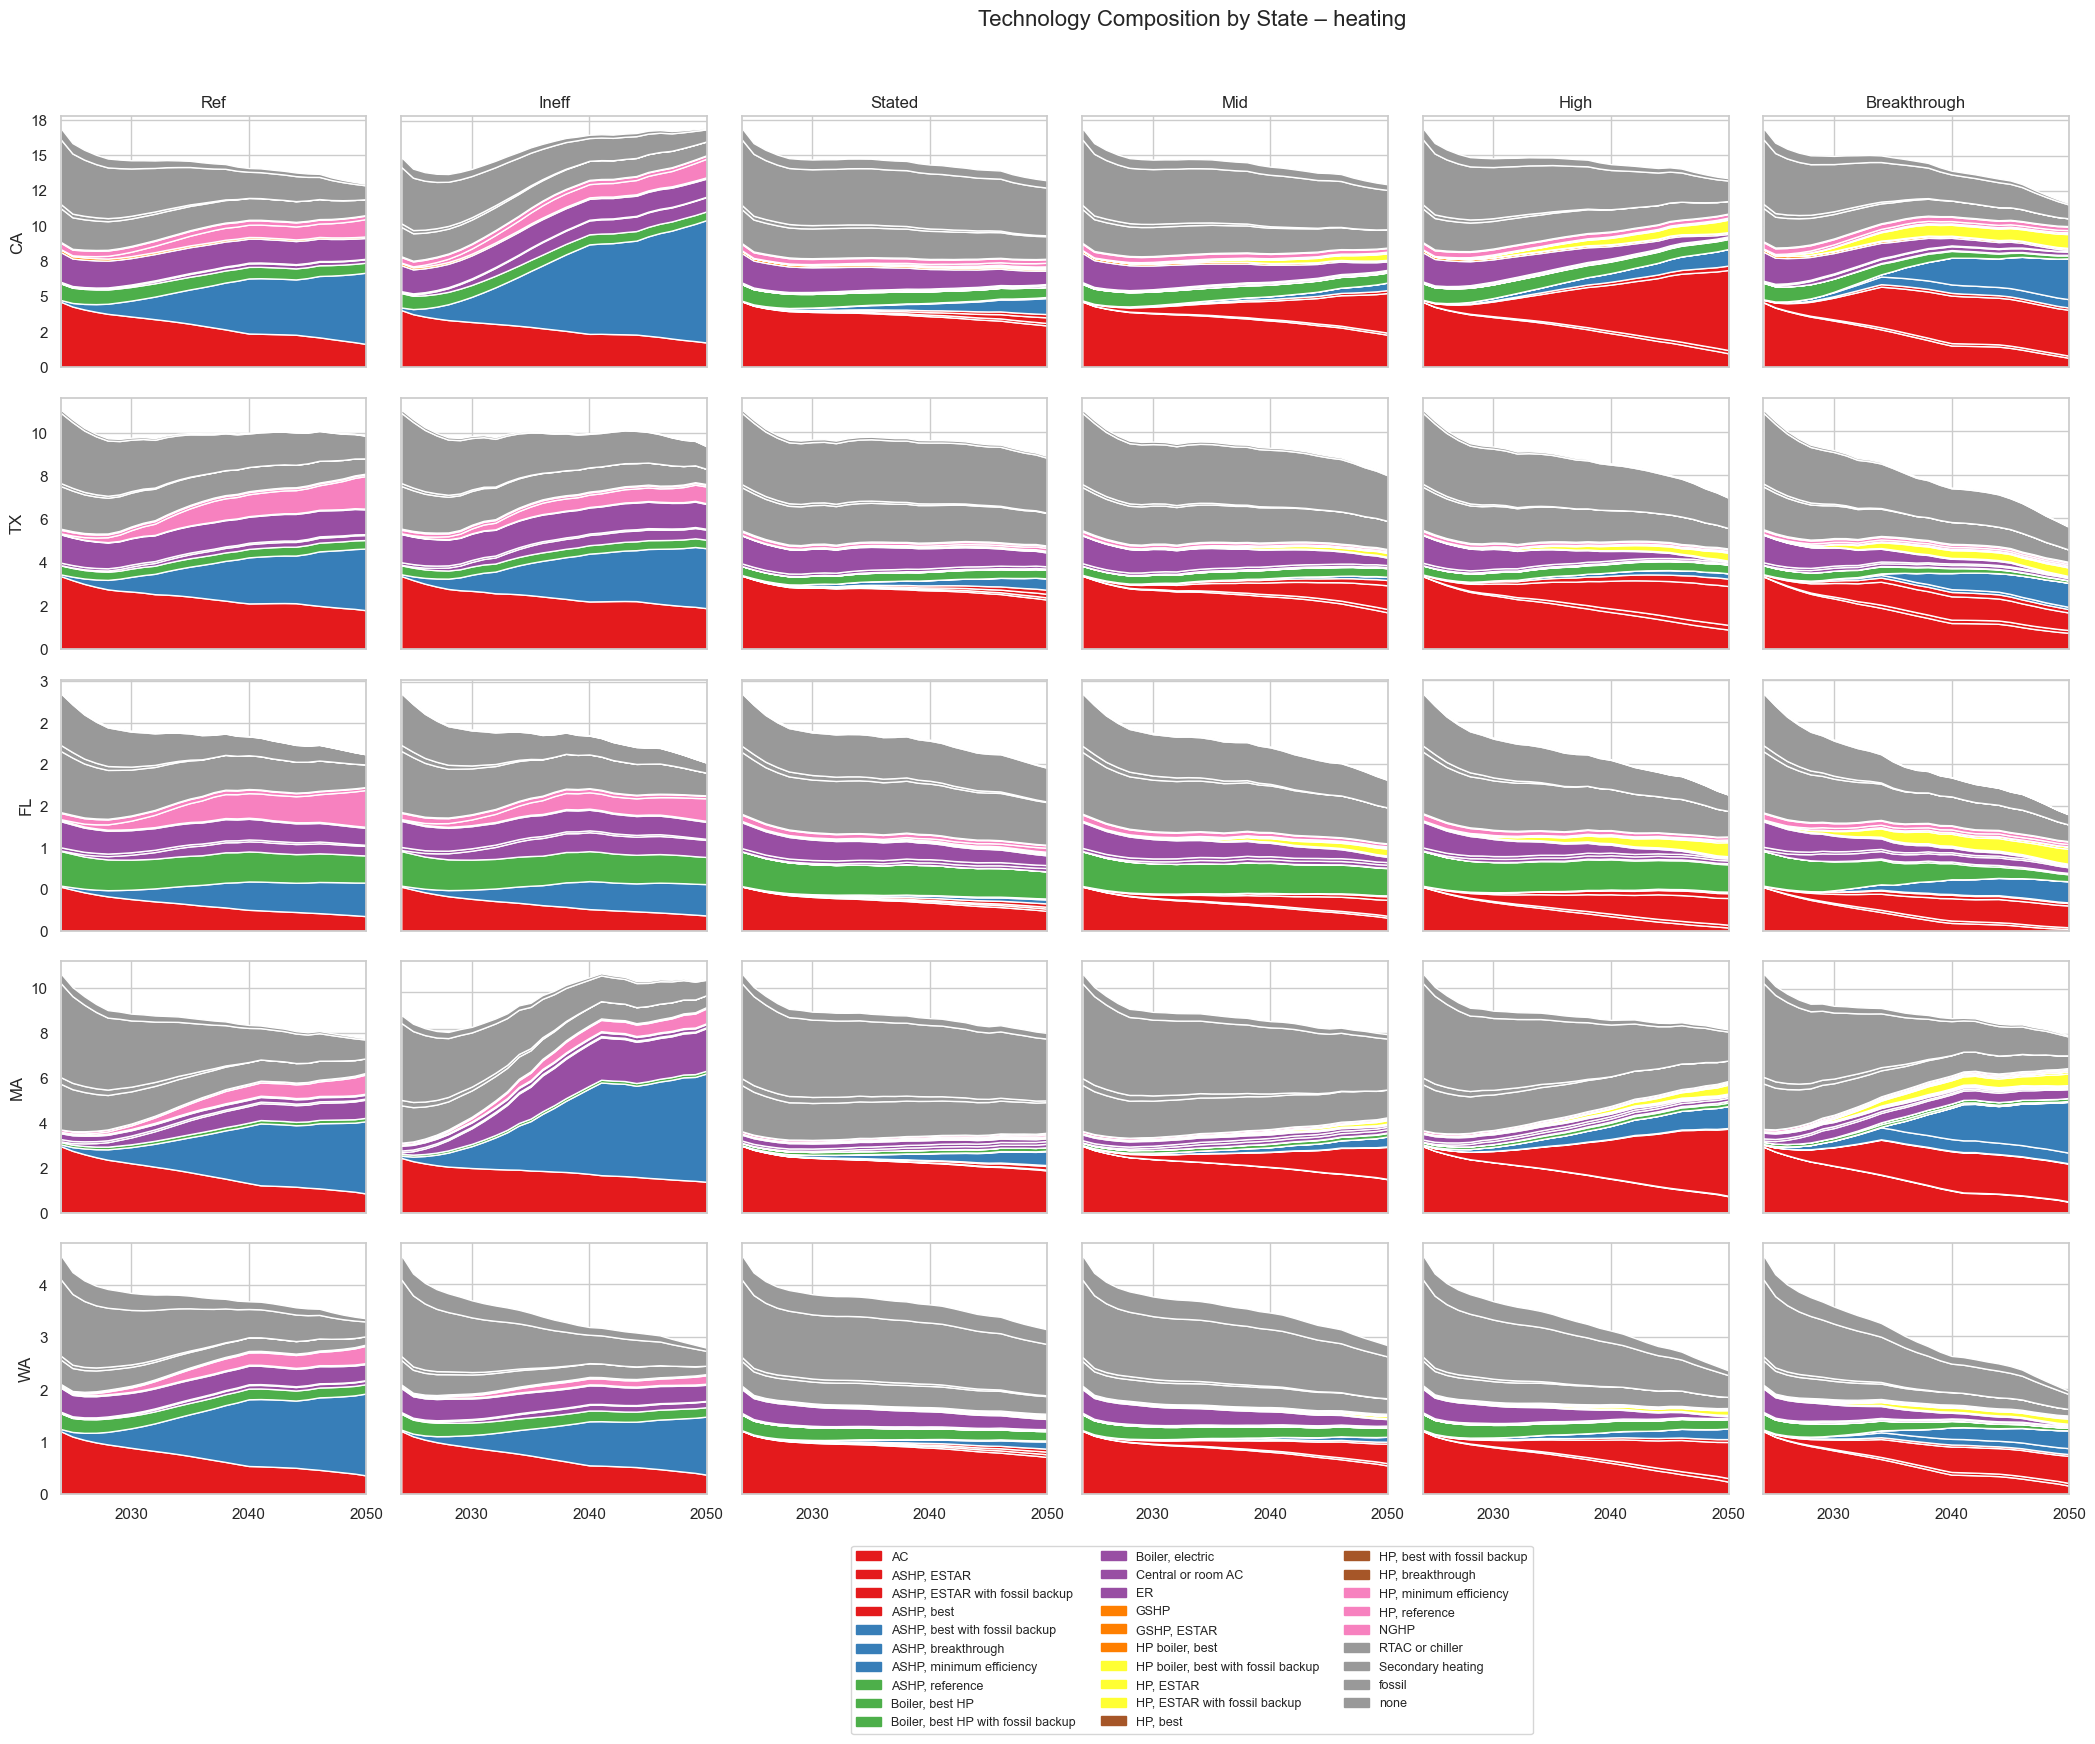

In [265]:
heating_states = ['CA', 'TX', 'FL', 'MA', 'WA']
combined_df_heating = combined_df[combined_df['end_use'].isin(['Heating (Equip.)'])]
plot_enduses_by_states(combined_df_heating,  heating_states,  'heating')

C:\Users\vapeu\AppData\Local\Temp\ipykernel_10896\303169120.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set1', len(measures))


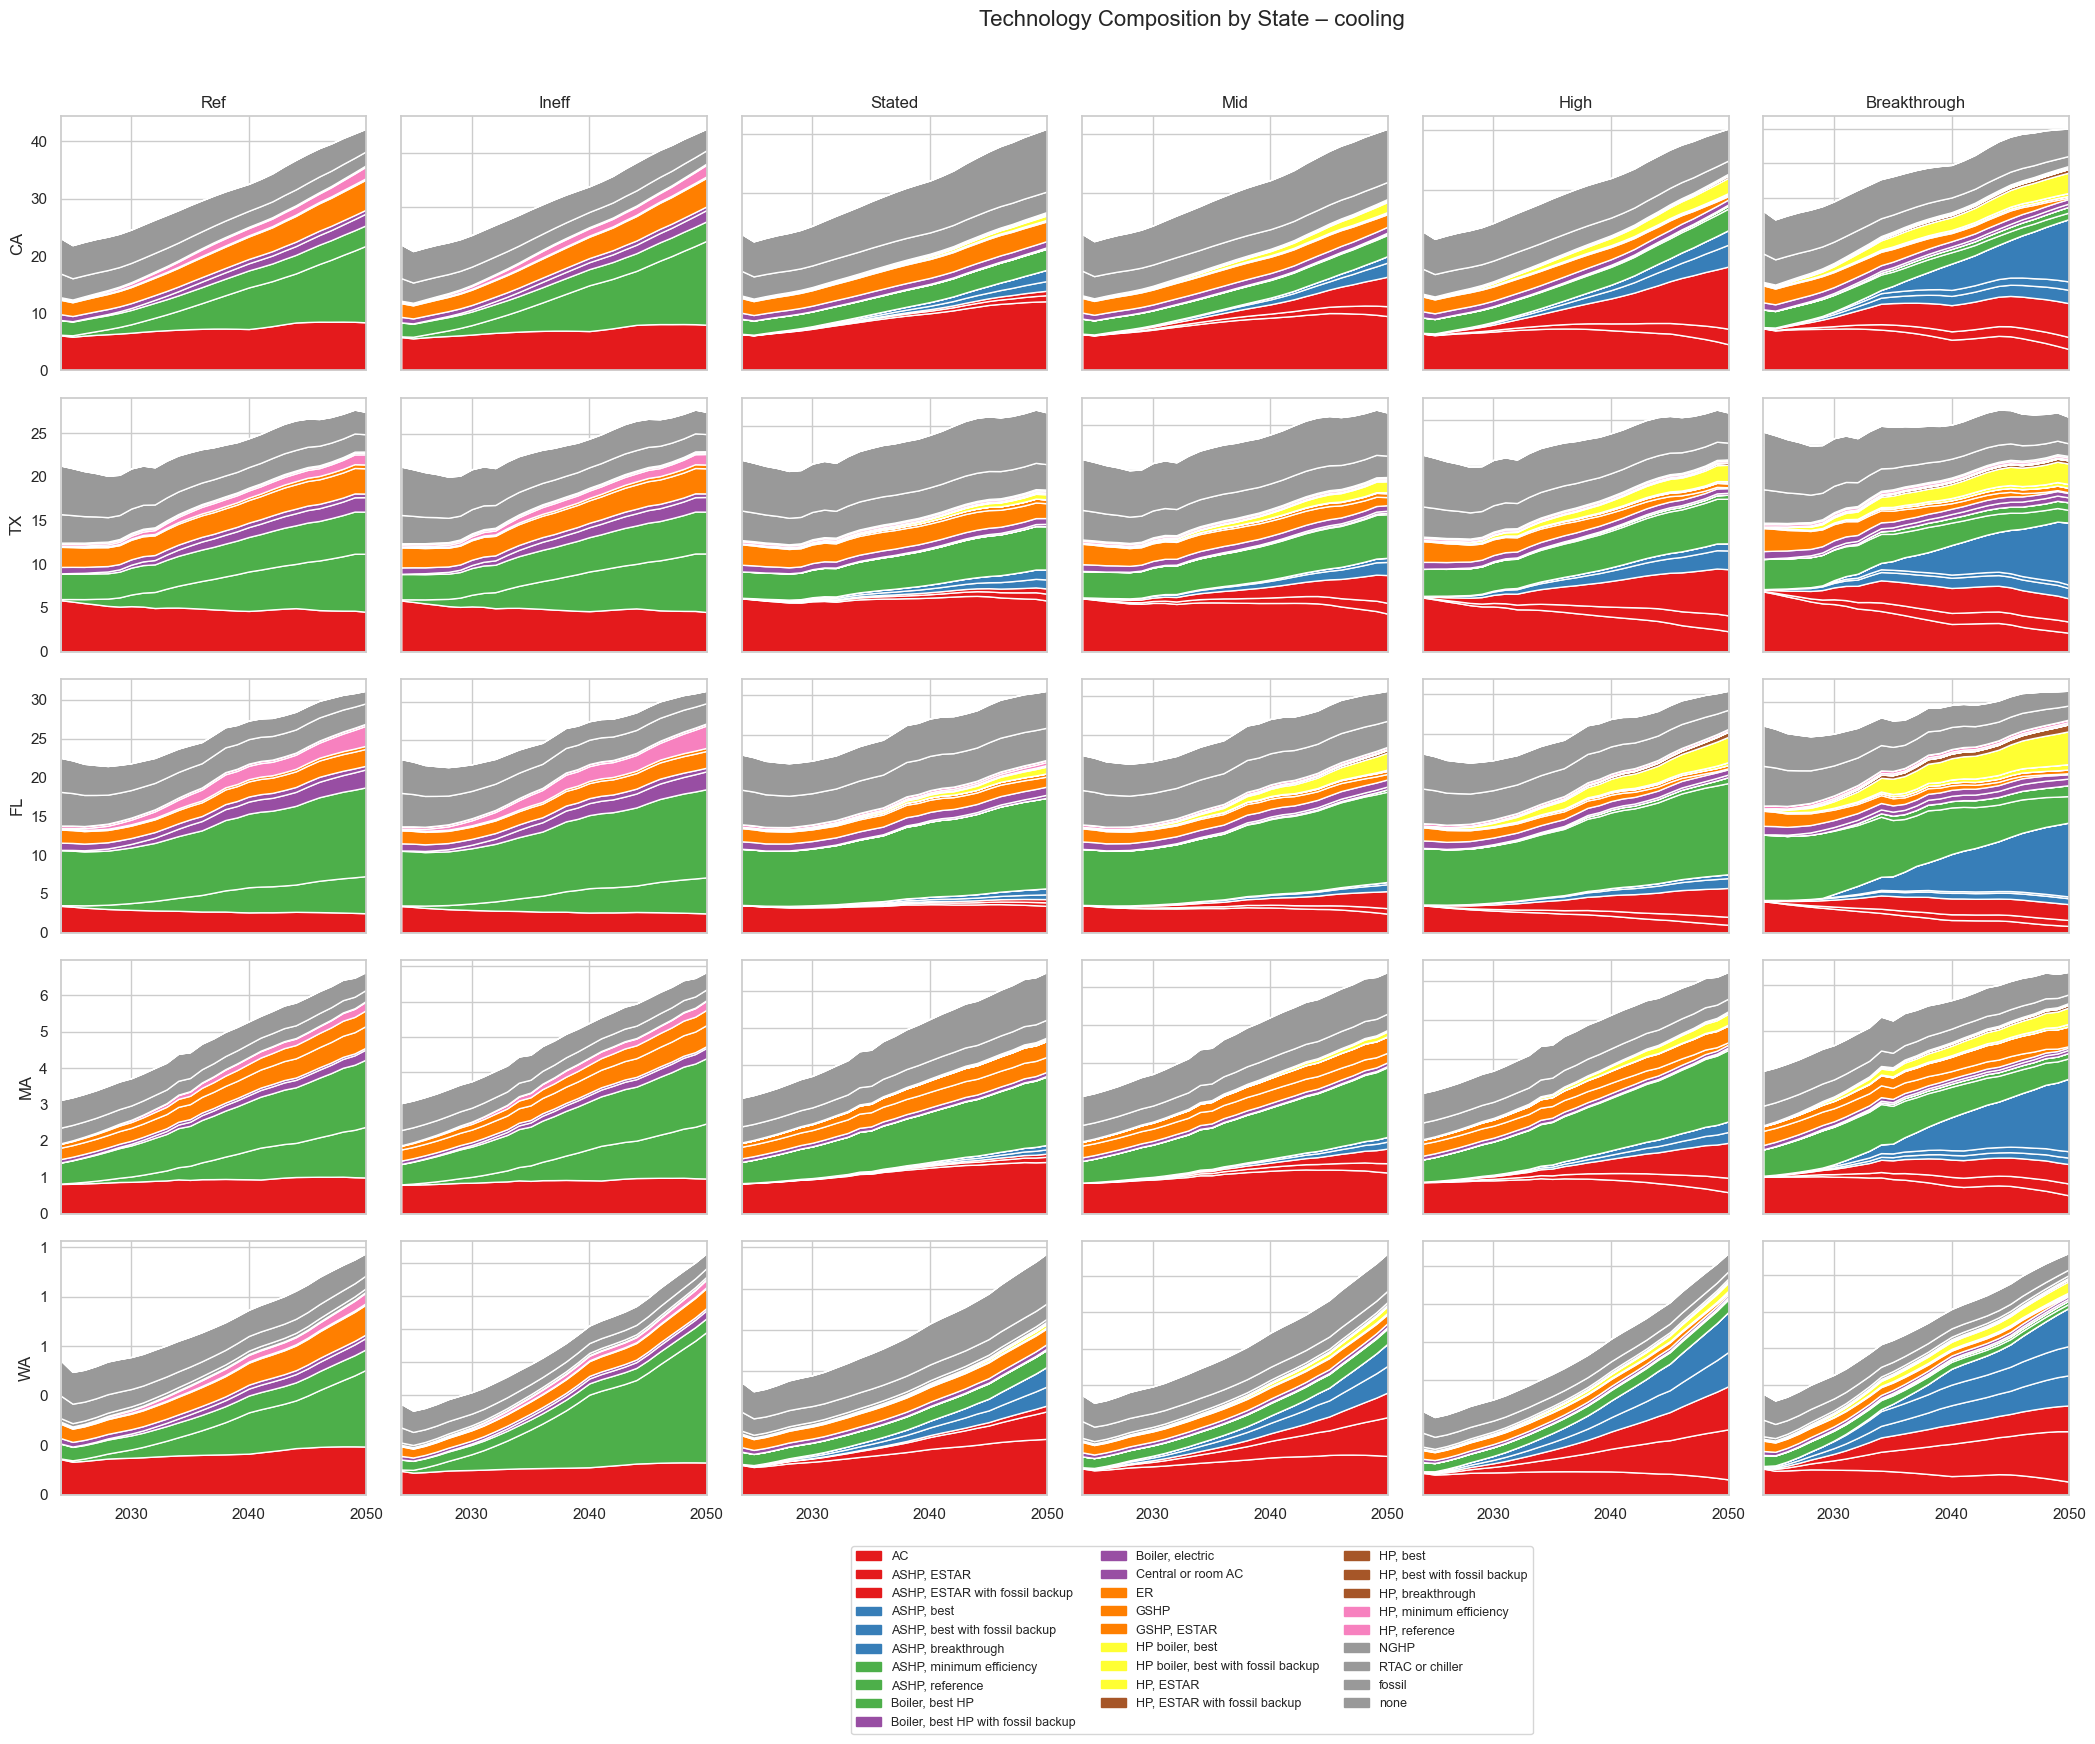

In [266]:
cooling_states = ['CA', 'TX', 'FL', 'MA', 'WA']
combined_df_cooling = combined_df[combined_df['end_use'].isin(['Cooling (Equip.)'])]
plot_enduses_by_states(combined_df_cooling,  cooling_states,  'cooling')

In [268]:
combined_df_heating_saving = combined_df_heating_saving.merge(
    measure_map[['meas', 'measure_desc_simple']],
    on='meas',
    how='left'
)
combined_df_cooling_saving = combined_df_cooling_saving.merge(
    measure_map[['meas', 'measure_desc_simple']],
    on='meas',
    how='left'
)

C:\Users\vapeu\AppData\Local\Temp\ipykernel_10896\3547548738.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set1', len(measures))


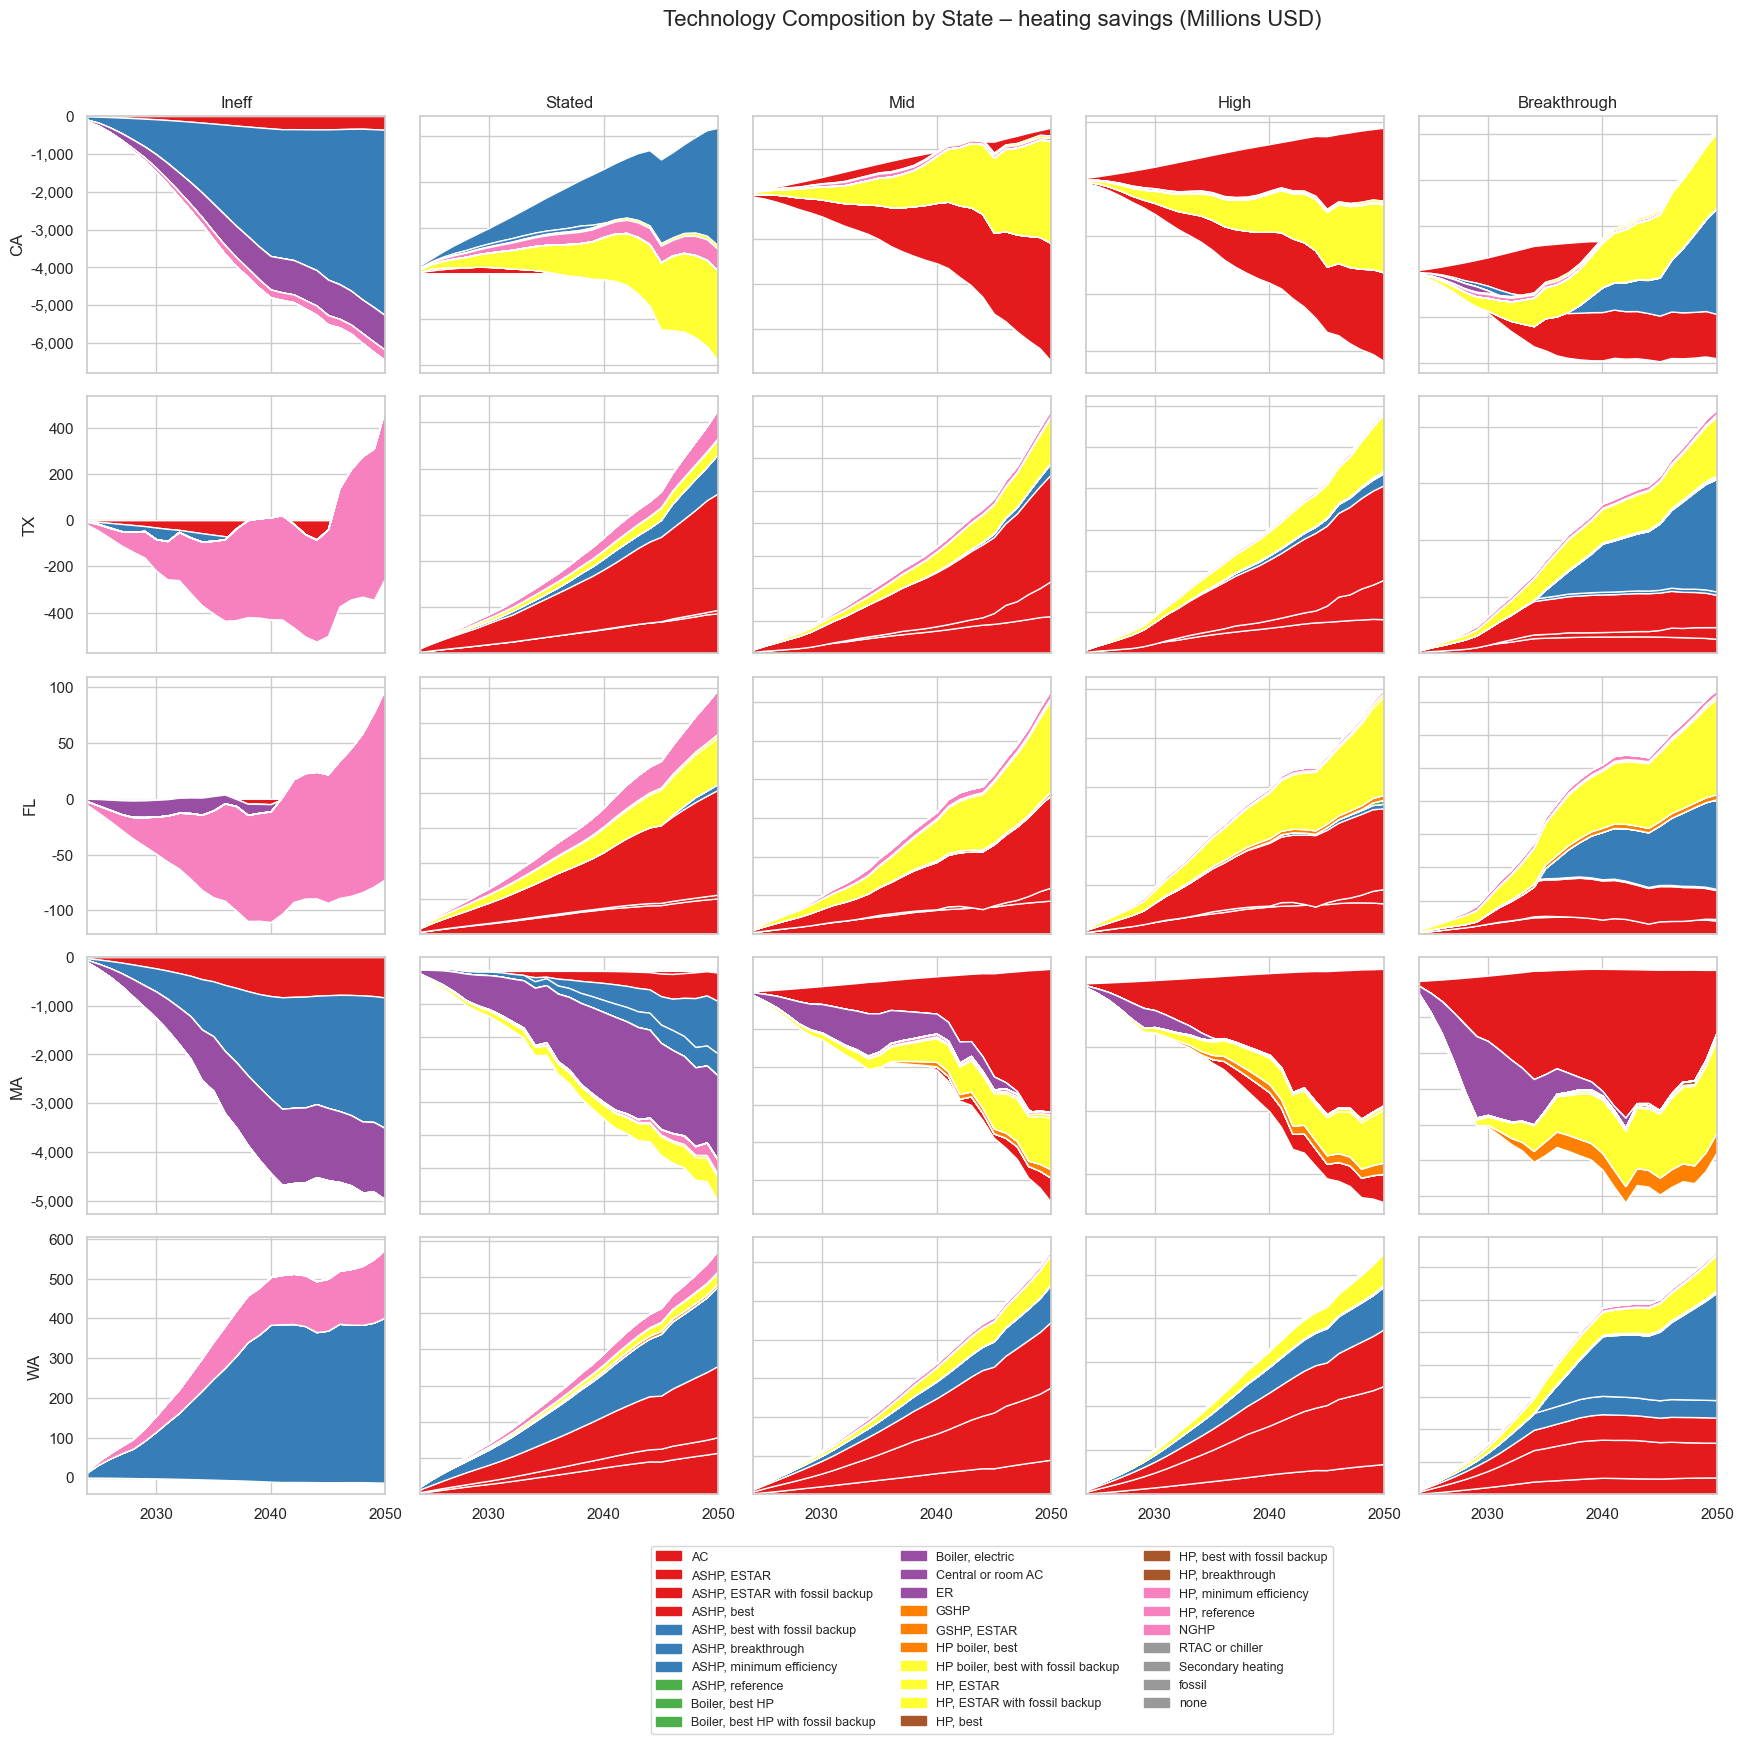

In [277]:
plot_enduses_by_states(combined_df_heating_saving,  heating_states,  'heating savings (Millions USD)')

C:\Users\vapeu\AppData\Local\Temp\ipykernel_10896\3547548738.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set1', len(measures))


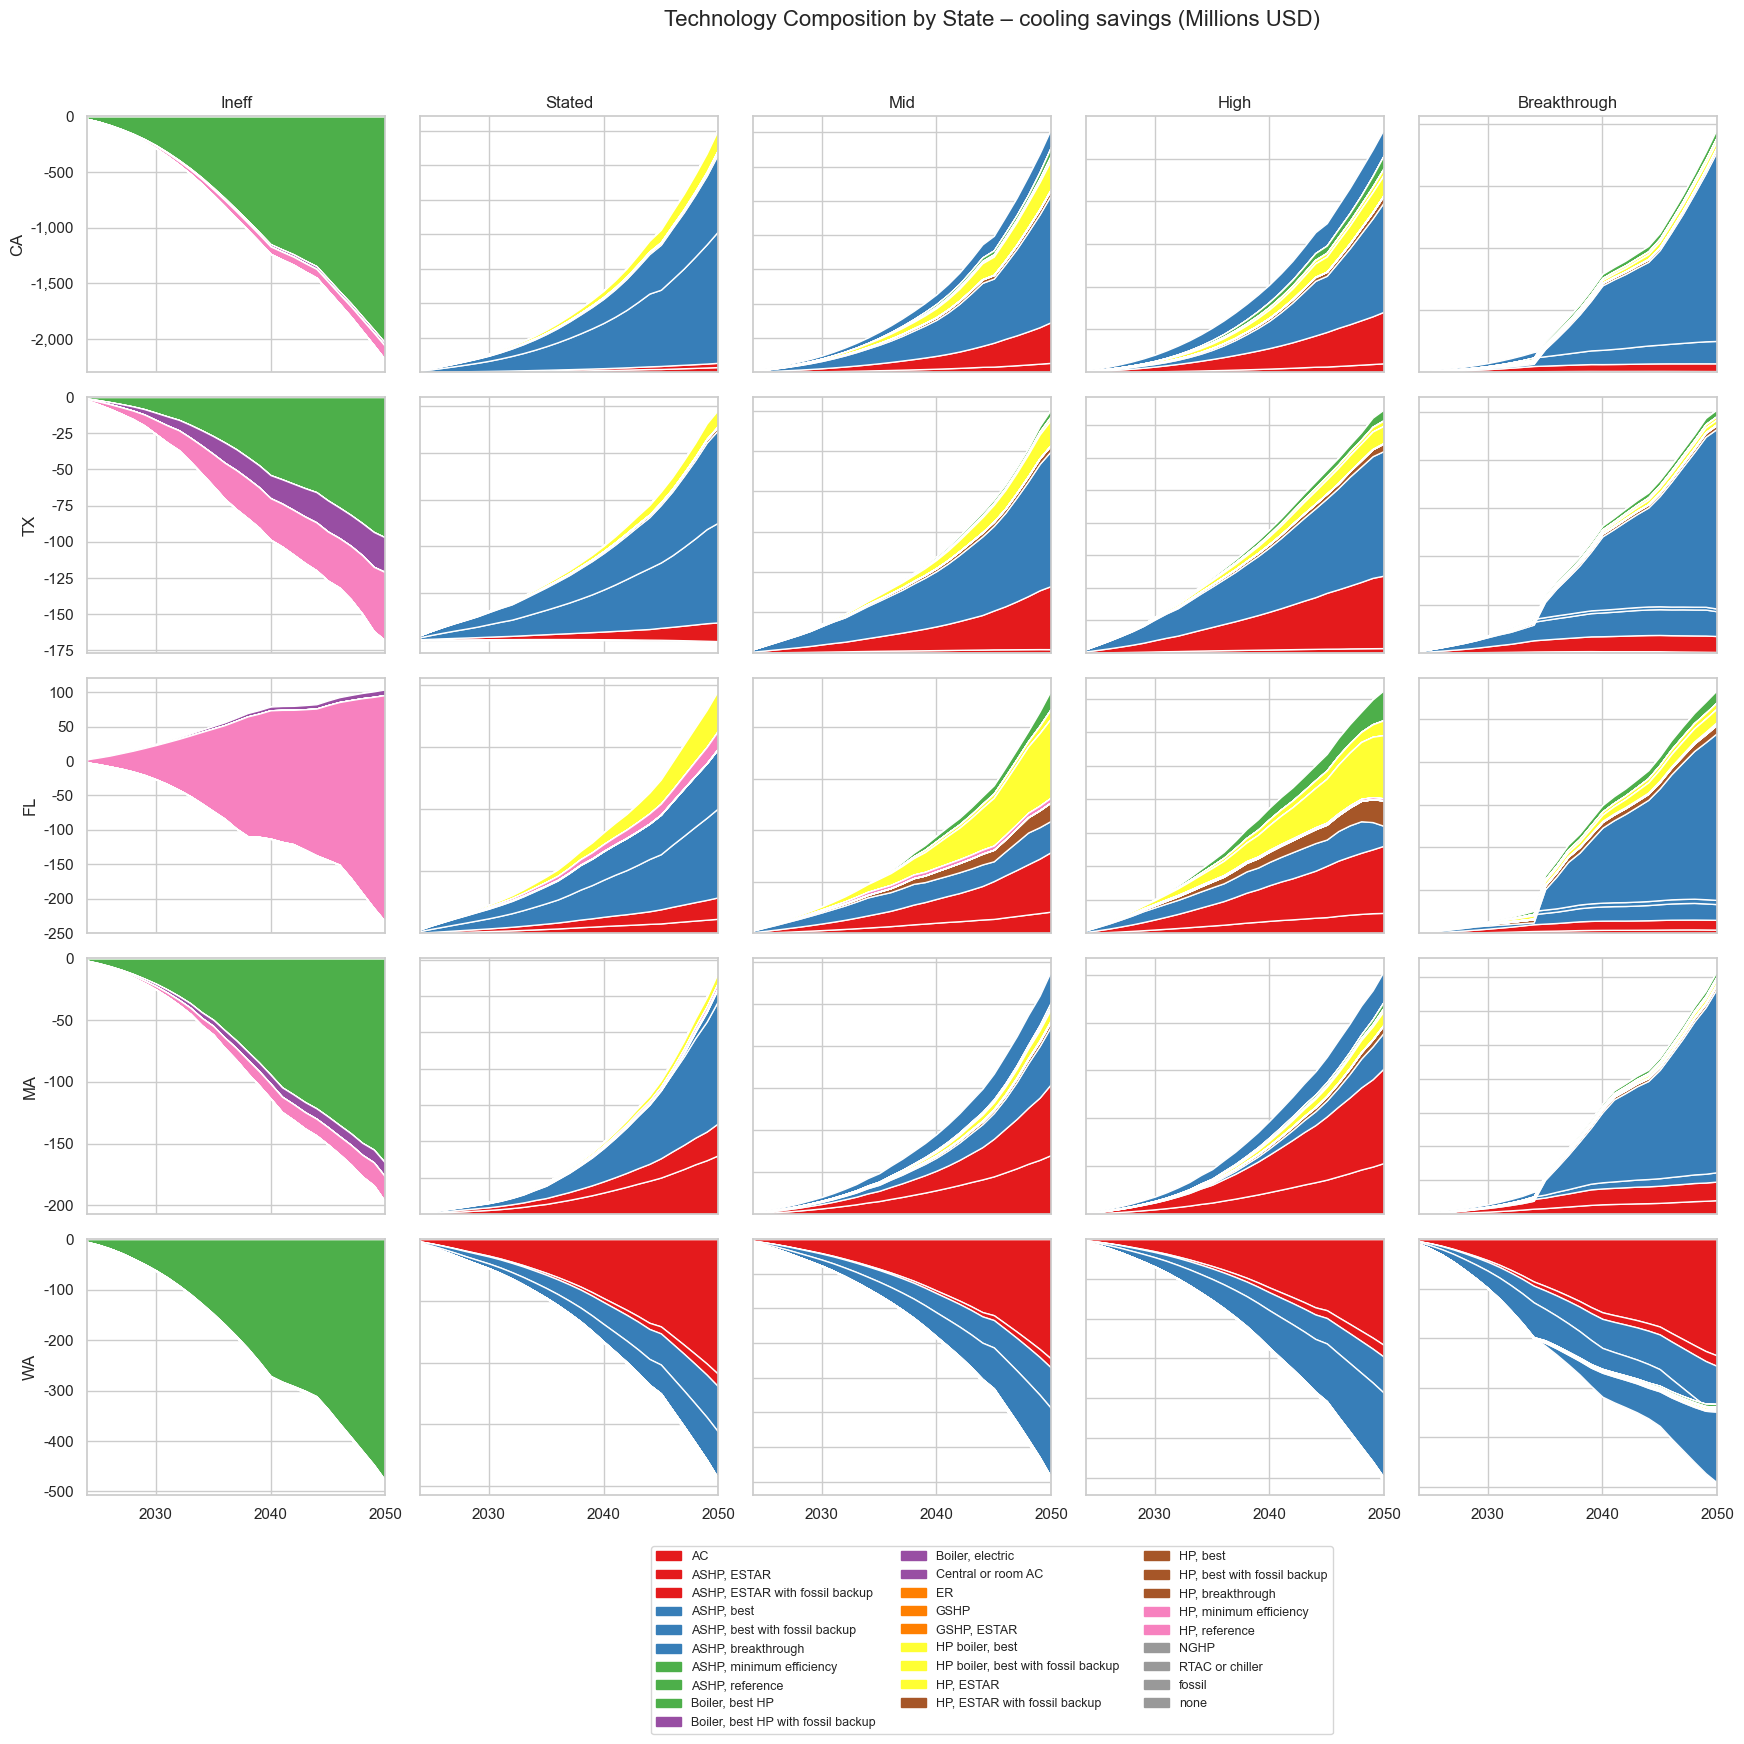

In [278]:
plot_enduses_by_states(combined_df_cooling_saving,  cooling_states,  'cooling savings (Millions USD)')